<h1 style="text-align: center; font-weight: 900;"> Clustering Analysis of European Football Player Statistics </h1>

In this project, I want to analyze a dataset of European professional football players. I focus more on the `players_data-2024_2025.csv` dataset. This dataset contains statistics of European professional football players in the 2024-2025 season who play in the top 5 European leagues. I do clustering by grouping the roles of players in each position. I got inspiration from the following notebook [Football players visualization](#References). Here I want to adopt the notebook.

# **Import Library & Setup Notebook**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

/kaggle/input/football-players-stats-2024-2025/players_data_light-2024_2025.csv
/kaggle/input/football-players-stats-2024-2025/players_data-2024_2025.csv


# **Loading Dataset**

In [2]:
# Load dataset
fps = pd.read_csv('/kaggle/input/football-players-stats-2024-2025/players_data-2024_2025.csv')

# I just took some columns based on the explanation in the dataset description.
basic_info = ["Player", "Nation", "Pos", "Comp", "Age", "Squad", "Born"]
playing_time_n_appearances = ["MP", "Starts", "Min", "90s"]
attacking_stats = ["Gls", "Ast", "G+A", "xG", "xAG", "npxG", "G-PK"]
defensive_stats = ["Tkl", "TklW", "Blocks", "Int", "Tkl+Int", "Clr", "Err"]
passing_n_creativity_stats = ["PrgP", "PrgC", "KP", "Ast_stats_passing", "xA", "PPA"]
goalkeeping_stats = ["GA", "Saves", "Save%", "CS", "CS%", "PKA", "PKsv"]
possession_n_ball_control = ["Touches", "Carries", "PrgR", "Mis", "Dis"]
miscellaneous_stats = ["CrdY", "CrdR", "PKwon", "PKcon", "Recov"]

# Merge all columns
required_columns = (
    basic_info +
    playing_time_n_appearances +
    attacking_stats +
    defensive_stats +
    passing_n_creativity_stats +
    goalkeeping_stats +
    possession_n_ball_control +
    miscellaneous_stats
)

# Create a dataframe
fps = fps[required_columns]
fps.head()

,Player,Nation,Pos,Comp,Age,Squad,Born,MP,Starts,Min,...,Touches,Carries,PrgR,Mis,Dis,CrdY,CrdR,PKwon,PKcon,Recov
0,Max Aarons,eng ENG,DF,eng Premier League,24.0,Bournemouth,2000.0,3,1,86,...,73,41,3,1,0,0,0,0,0,7
1,Max Aarons,eng ENG,"DF,MF",es La Liga,24.0,Valencia,2000.0,4,1,120,...,85,46,10,3,1,2,0,0,0,7
2,Rodrigo Abajas,es ESP,DF,es La Liga,21.0,Valencia,2003.0,1,1,65,...,36,13,3,0,2,1,0,0,0,2
3,James Abankwah,ie IRL,"DF,MF",it Serie A,20.0,Udinese,2004.0,6,0,88,...,65,29,1,1,3,1,0,0,0,7
4,Keyliane Abdallah,fr FRA,FW,fr Ligue 1,18.0,Marseille,2006.0,1,0,3,...,4,1,0,1,0,0,0,0,0,0


# **Exploratory Data Analysis (EDA)**

In [3]:
# Understanding data structures
fps.info(show_counts=True,verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2854 entries, 0 to 2853
Data columns (total 48 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Player             2854 non-null   object 
 1   Nation             2847 non-null   object 
 2   Pos                2854 non-null   object 
 3   Comp               2854 non-null   object 
 4   Age                2846 non-null   float64
 5   Squad              2854 non-null   object 
 6   Born               2846 non-null   float64
 7   MP                 2854 non-null   int64  
 8   Starts             2854 non-null   int64  
 9   Min                2854 non-null   int64  
 10  90s                2854 non-null   float64
 11  Gls                2854 non-null   int64  
 12  Ast                2854 non-null   int64  
 13  G+A                2854 non-null   int64  
 14  xG                 2854 non-null   float64
 15  xAG                2854 non-null   float64
 16  npxG               2854 

In [4]:
# Missing values analysis
missing_values = fps.isnull().sum()
more_miss = missing_values[missing_values > 0]
more_miss

Nation       7
Age          8
Born         8
GA        2642
Saves     2642
Save%     2648
CS        2642
CS%       2651
PKA       2642
PKsv      2642
dtype: int64

There are some missing values that are actually true in the goalkeeper statistics column, because players other than the goalkeeper position do not have goalkeeper statistics. But here there are some columns that have missing values, namely `Nation`, `Age`, and `Born`.

In [5]:
# Identification and analysis of duplicate data
player_counts = fps['Player'].value_counts()
player_switch_club = player_counts[player_counts > 1].index
player_switch_club

Index(['Max Aarons', 'Odsonne Édouard', 'Michael Folorunsho', 'Evan Ferguson',
       'João Félix', 'Nicolò Fagioli', 'Julio Enciso', 'Elif Elmas',
       'Anastasios Douvikas', 'Billy Gilmour',
       ...
       'Emmanuel Agbadou', 'Carles Aleñá', 'Akor Adams', 'Antony',
       'Samuel Amo-Ameyaw', 'Joseph Aidoo', 'Mathis Amougou',
       'Joachim Andersen', 'Carlos Alcaraz', 'Tammy Abraham'],
      dtype='object', name='Player', length=152)

There is a lot of duplicate data. The players data is the influence of mid-season transfers.

In [6]:
# Distribution analysis
fps.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Player,2854,2702,Max Aarons,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Nation,2847,113,es ESP,415,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pos,2854,10,DF,859,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Comp,2854,5,it Serie A,634,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,2846.0,NaN,NaN,NaN,25.018974,4.491624,15.0,22.0,25.0,28.0,41.0
Squad,2854,96,Valladolid,38,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Born,2846.0,NaN,NaN,NaN,1998.637034,4.497922,1982.0,1996.0,1999.0,2002.0,2008.0
MP,2854.0,NaN,NaN,NaN,19.024177,11.510177,1.0,9.0,20.0,30.0,38.0
Starts,2854.0,NaN,NaN,NaN,13.505256,11.331036,0.0,3.0,11.0,23.0,38.0
Min,2854.0,NaN,NaN,NaN,1212.222845,965.81979,1.0,317.25,1054.0,1996.75,3420.0


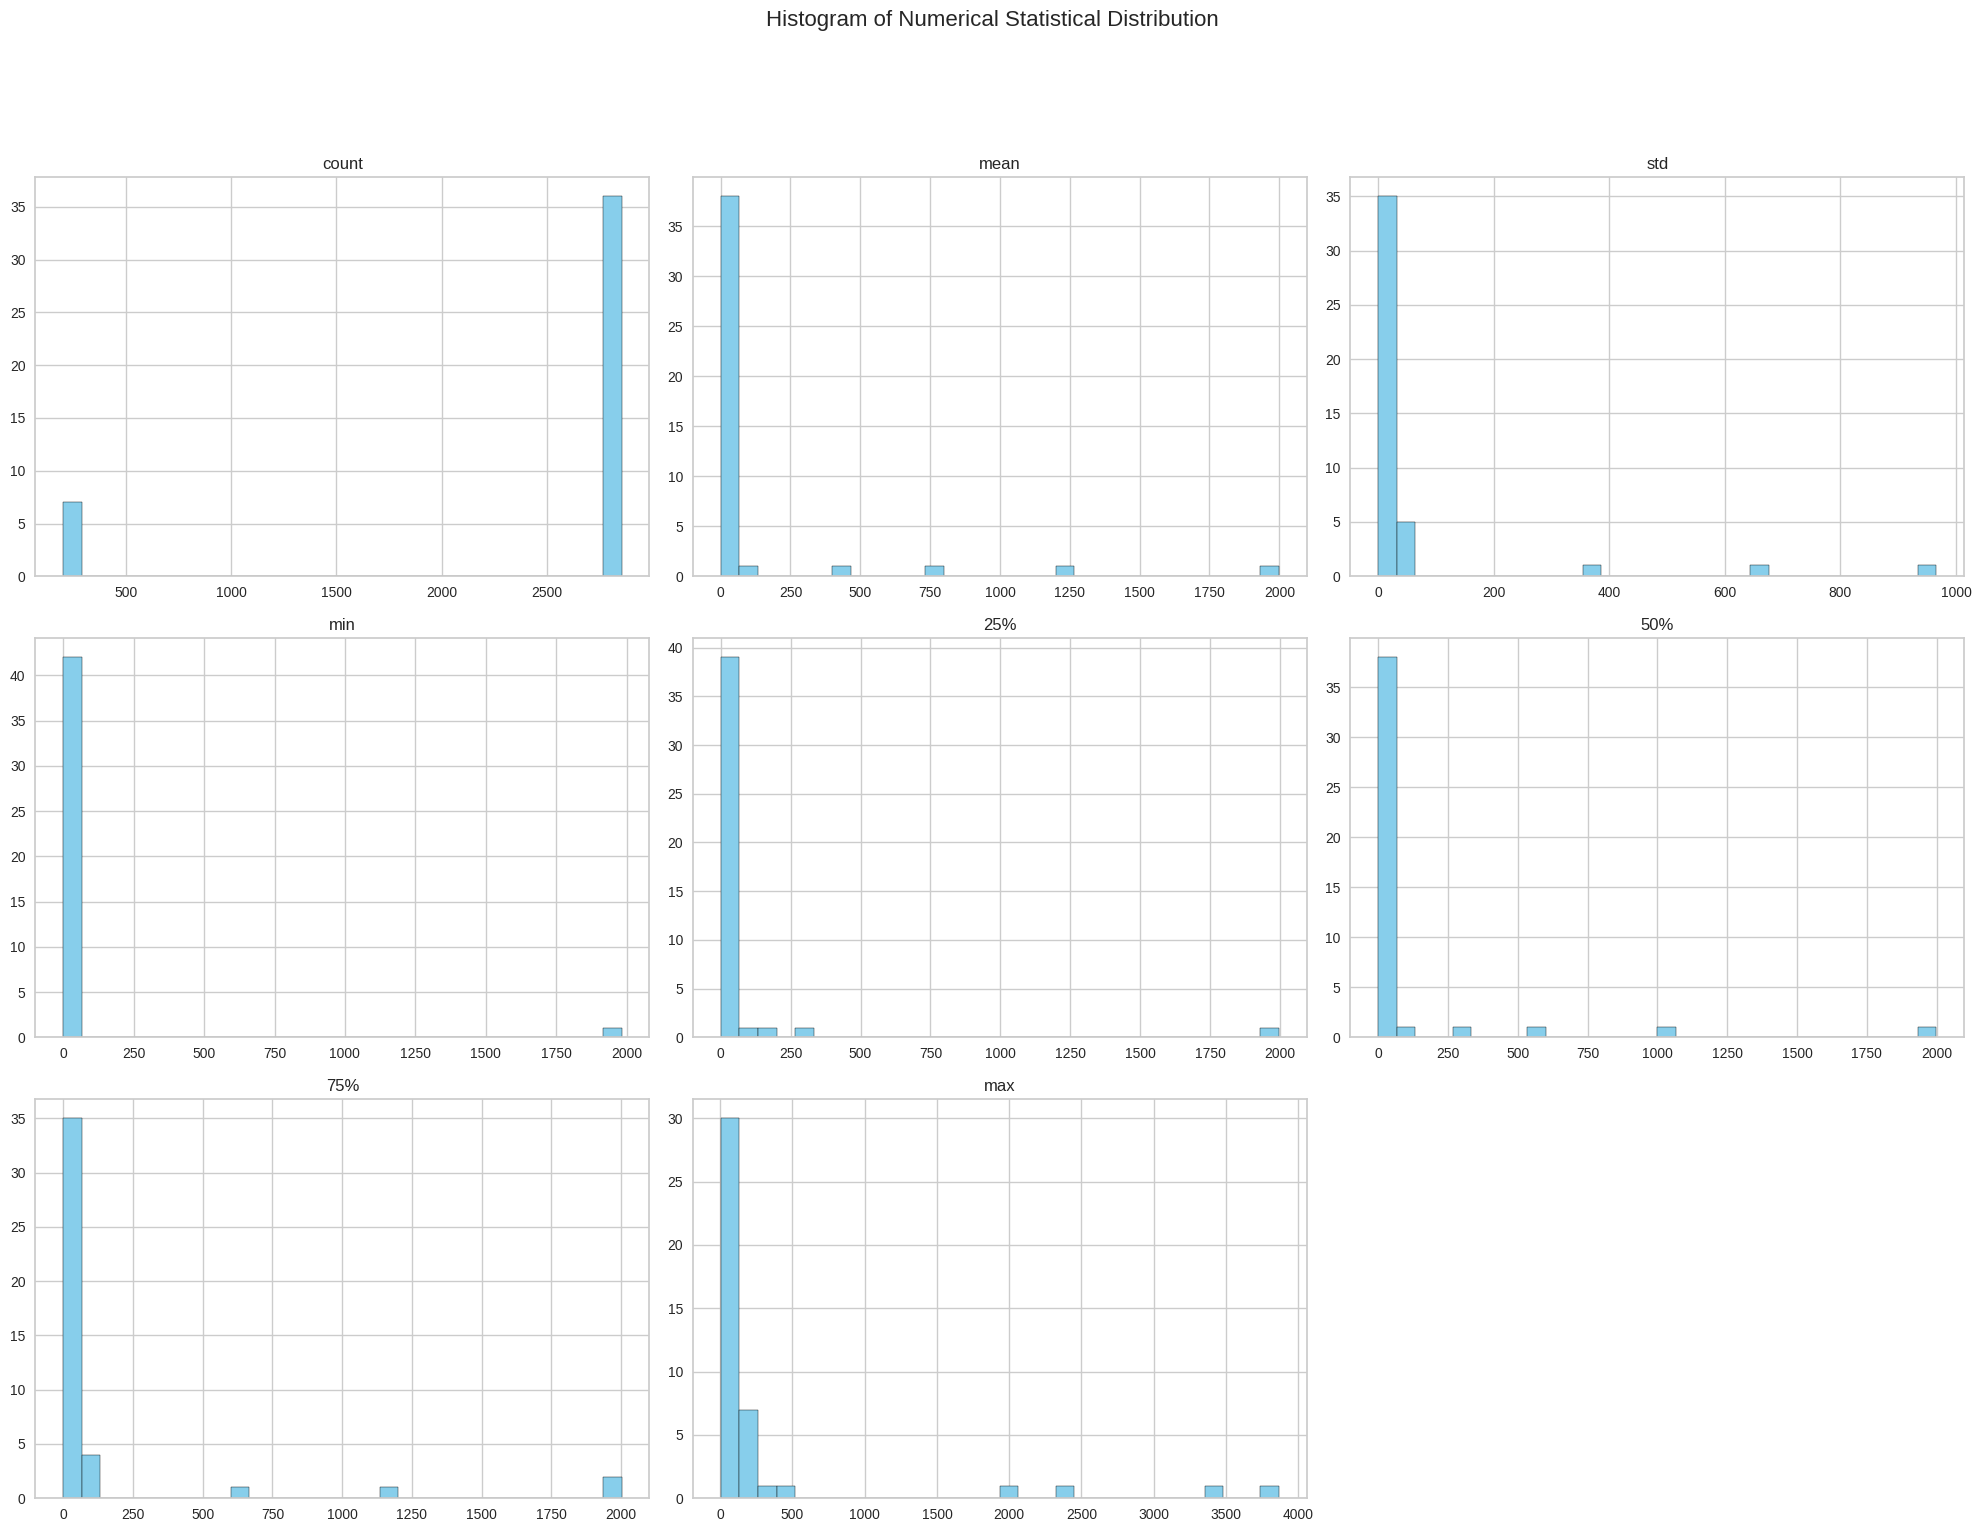

In [7]:
# Numerical statistics
numerical_columns = fps.select_dtypes(include=[np.number]).columns.tolist()
numerical_stats = fps[numerical_columns].describe().transpose()

# Creating histograms for statistical distribution analysis of numerical columns
numerical_stats.hist(
    figsize=(20, 15), 
    bins=30, 
    color='skyblue', 
    edgecolor='black'
)

plt.suptitle(
    'Histogram of Numerical Statistical Distribution', 
    fontsize=16, 
    y=1.02
)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

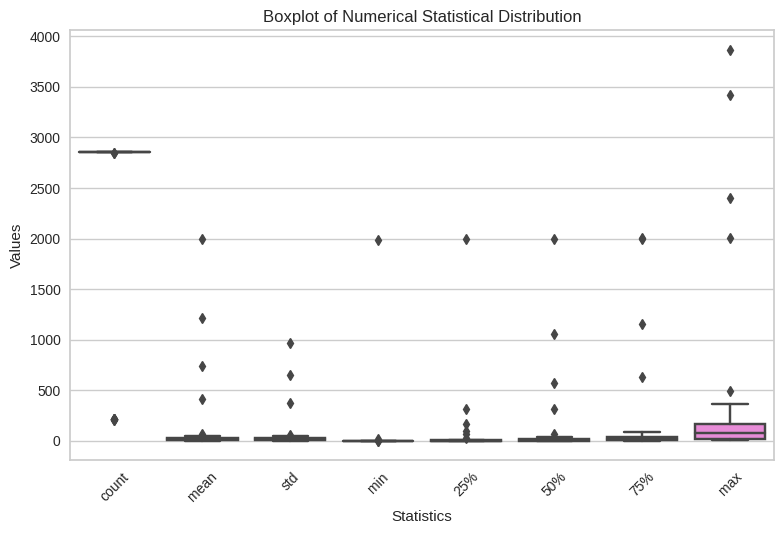

In [8]:
# Visualize using boxplot
sns.boxplot(data=numerical_stats)
plt.title('Boxplot of Numerical Statistical Distribution')
plt.xlabel('Statistics')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# Check the relationship between variables using a correlation matrix
correlation_matrix = fps[numerical_columns].corr()
correlation_matrix

,Age,Born,MP,Starts,Min,90s,Gls,Ast,G+A,xG,...,Touches,Carries,PrgR,Mis,Dis,CrdY,CrdR,PKwon,PKcon,Recov
Age,1.000000,-0.994414,0.234688,0.236985,0.241853,0.241893,0.065530,0.079028,0.079562,0.077734,...,0.222545,0.201604,0.034933,0.012437,-0.006857,0.149791,0.023370,0.018209,0.098721,0.153288
Born,-0.994414,1.000000,-0.237470,-0.238969,-0.244179,-0.244220,-0.065705,-0.080299,-0.080230,-0.078450,...,-0.225094,-0.203713,-0.037112,-0.013452,0.005196,-0.152137,-0.025826,-0.017981,-0.098115,-0.156765
MP,0.234688,-0.237470,1.000000,0.894219,0.914876,0.914882,0.447348,0.523849,0.536390,0.478973,...,0.810251,0.785406,0.575587,0.669012,0.609945,0.637127,0.174337,0.259360,0.211327,0.804360
Starts,0.236985,-0.238969,0.894219,1.000000,0.993931,0.993933,0.407827,0.492211,0.495290,0.423319,...,0.896190,0.866744,0.499321,0.594799,0.539353,0.646026,0.184792,0.230870,0.273197,0.849708
Min,0.241853,-0.244179,0.914876,0.993931,1.000000,0.999997,0.402649,0.486724,0.489329,0.419392,...,0.904442,0.875101,0.495446,0.588706,0.531056,0.647855,0.179391,0.228923,0.275146,0.851210
90s,0.241893,-0.244220,0.914882,0.993933,0.999997,1.000000,0.402612,0.486674,0.489282,0.419369,...,0.904453,0.875108,0.495386,0.588677,0.531003,0.647870,0.179398,0.228886,0.275187,0.851204
Gls,0.065530,-0.065705,0.447348,0.407827,0.402649,0.402612,1.000000,0.553482,0.933849,0.936950,...,0.237743,0.261323,0.665835,0.707619,0.653901,0.205207,0.047432,0.431147,-0.045525,0.279163
Ast,0.079028,-0.080299,0.523849,0.492211,0.486724,0.486674,0.553482,1.000000,0.814755,0.578863,...,0.444638,0.454040,0.756920,0.640618,0.627156,0.299251,0.063664,0.305864,-0.013245,0.500339
G+A,0.079562,-0.080230,0.536390,0.495290,0.489329,0.489282,0.933849,0.814755,1.000000,0.900856,...,0.356454,0.376907,0.788582,0.767726,0.724548,0.271368,0.060361,0.431499,-0.037381,0.409210
xG,0.077734,-0.078450,0.478973,0.423319,0.419392,0.419369,0.936950,0.578863,0.900856,1.000000,...,0.241793,0.263295,0.686972,0.743758,0.680540,0.228406,0.060970,0.456520,-0.046990,0.290334


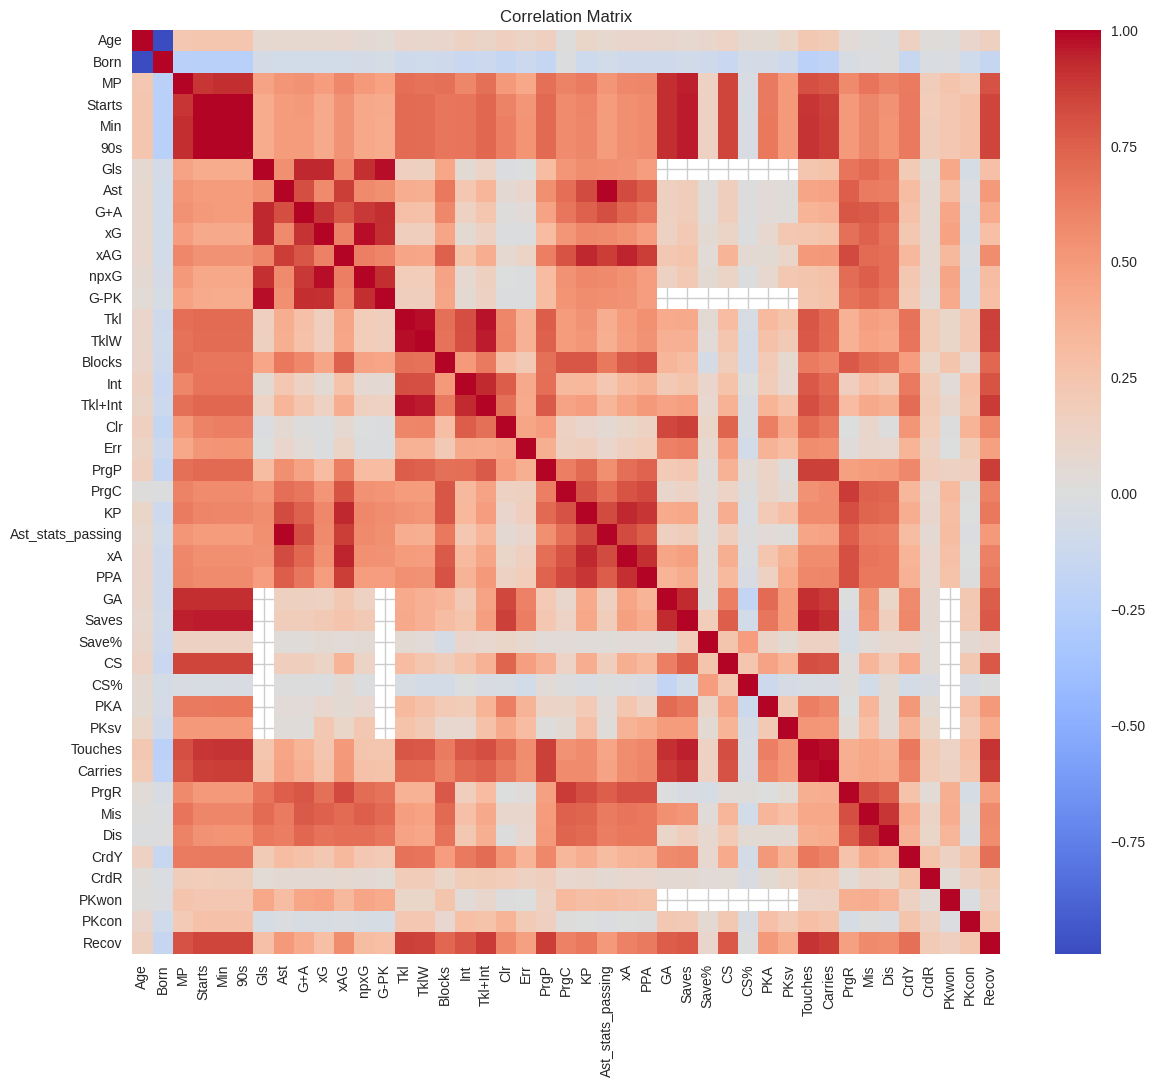

In [10]:
# Visualize the correlation matrix using heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

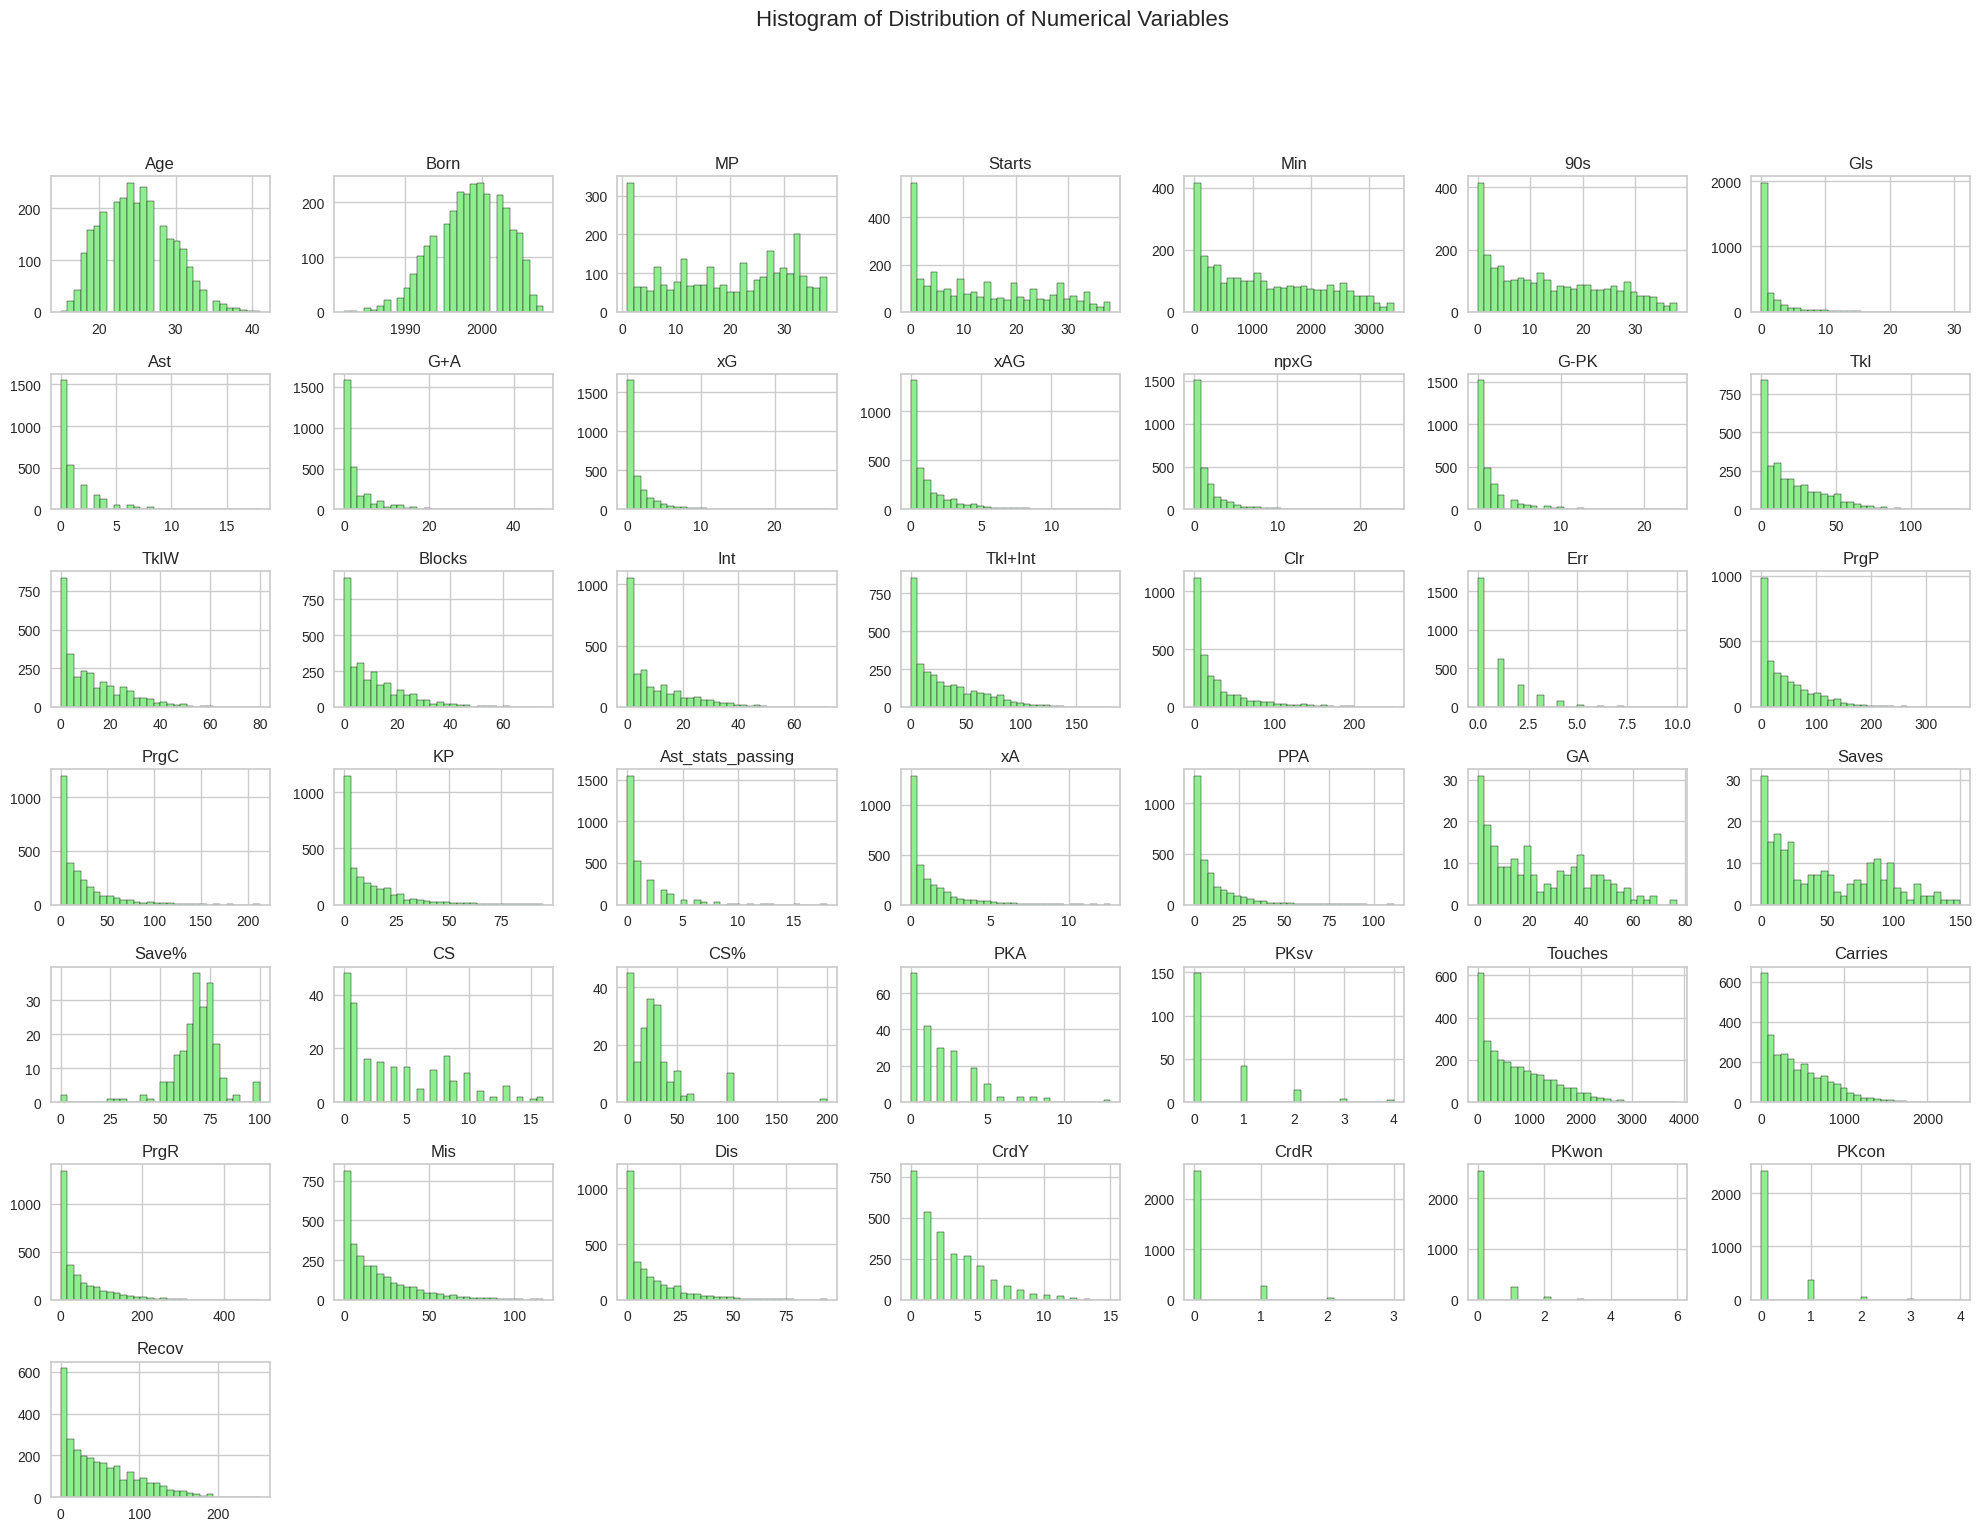

In [11]:
# Visualize the correlation matrix using histogram
fps[numerical_columns].hist(
    figsize=(20, 15), 
    bins=30, 
    color='lightgreen', 
    edgecolor='black'
)

plt.suptitle(
    'Histogram of Distribution of Numerical Variables', 
    fontsize=16, 
    y=1.02
)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

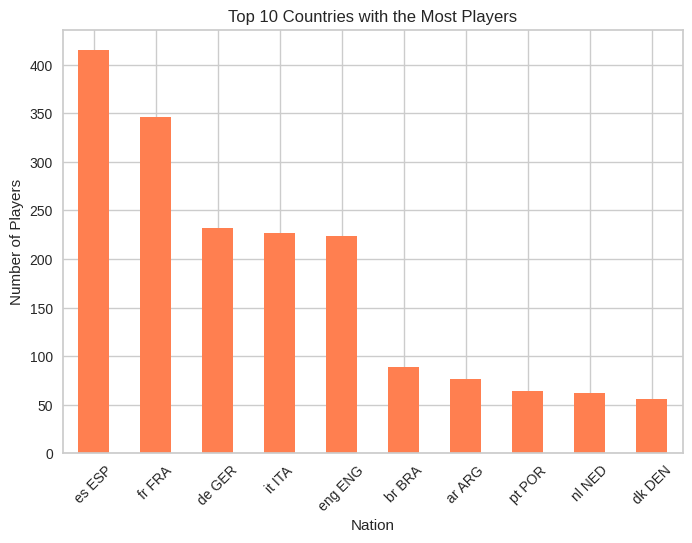

In [12]:
# Visualization of the number of players based on the top 10 countries
top_nations = fps['Nation'].value_counts().head(10)

top_nations.plot(kind='bar', color='coral')
plt.title('Top 10 Countries with the Most Players')
plt.xlabel('Nation')
plt.ylabel('Number of Players')
plt.xticks(rotation=45)
plt.show()

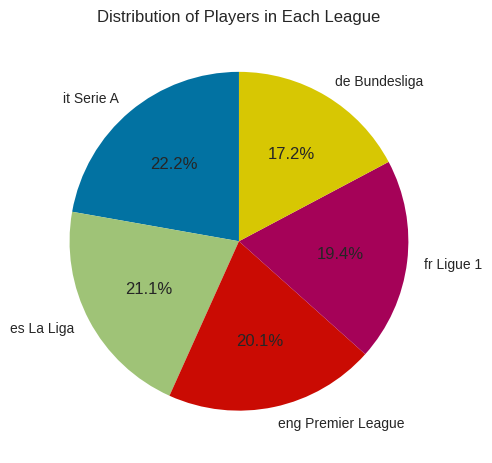

In [13]:
# Visualization of player distribution in each league
comp_counts = fps["Comp"].value_counts()

plt.pie(comp_counts.values, 
        labels=comp_counts.index,
        autopct='%1.1f%%',
        startangle=90)

plt.title('Distribution of Players in Each League')
plt.show()

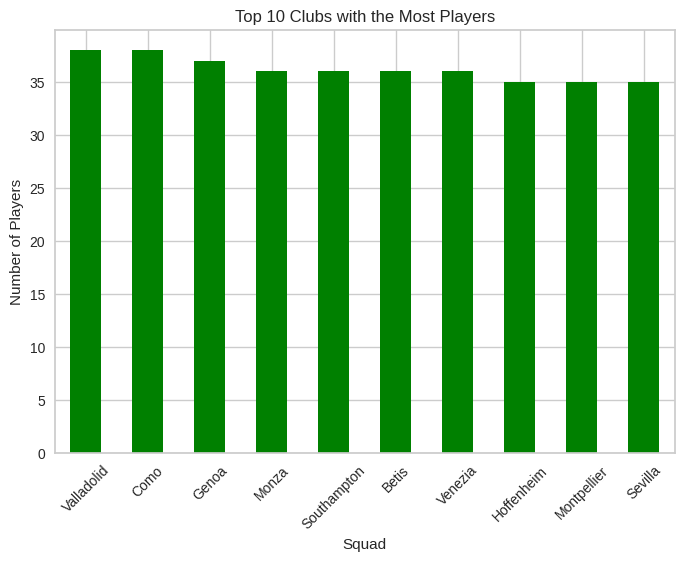

In [14]:
# Visualization of player distribution in each club
top_squad = fps['Squad'].value_counts().head(10)

top_squad.plot(kind='bar', color='green')
plt.title('Top 10 Clubs with the Most Players')
plt.xlabel('Squad')
plt.ylabel('Number of Players')
plt.xticks(rotation=45)
plt.show()

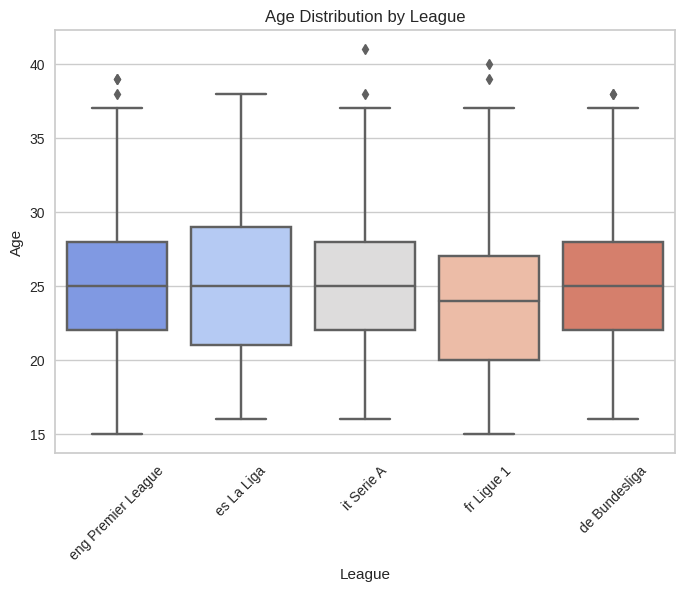

In [15]:
# Visualization of player age distribution by league
sns.boxplot(x='Comp', y='Age', data=fps, palette='coolwarm')
plt.title('Age Distribution by League')
plt.xlabel('League')
plt.ylabel('Age')
plt.xticks(rotation=45)
plt.show()

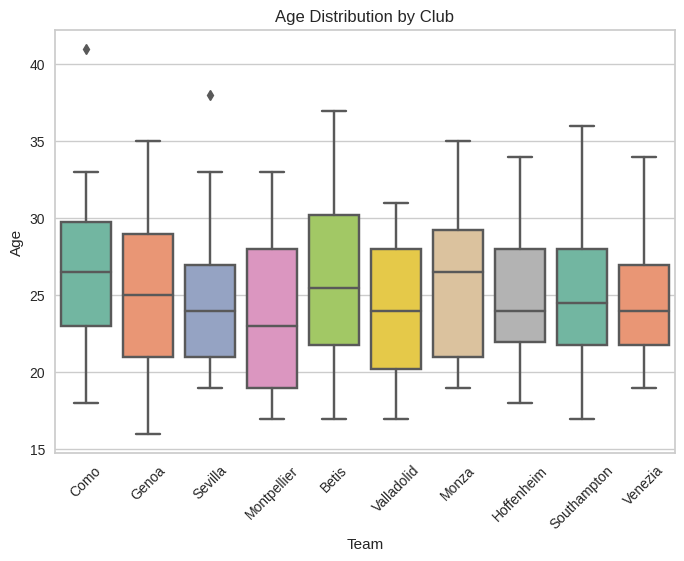

In [16]:
# Visualization of player age distribution based on the top 10 clubs with the most players
sns.boxplot(x='Squad', y='Age',
            data=fps[fps['Squad'].isin(top_squad.index)], 
            palette='Set2')
plt.title('Age Distribution by Club')
plt.xlabel('Team')
plt.ylabel('Age')
plt.xticks(rotation=45)
plt.show()

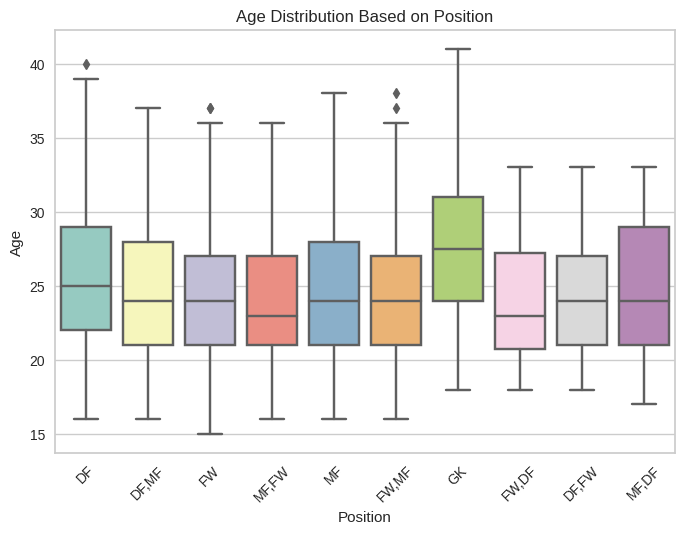

In [17]:
# Visualization of player age distribution by position
sns.boxplot(x='Pos', y='Age', data=fps, palette='Set3')
plt.title('Age Distribution Based on Position')
plt.xlabel('Position')
plt.ylabel('Age')
plt.xticks(rotation=45)
plt.show()

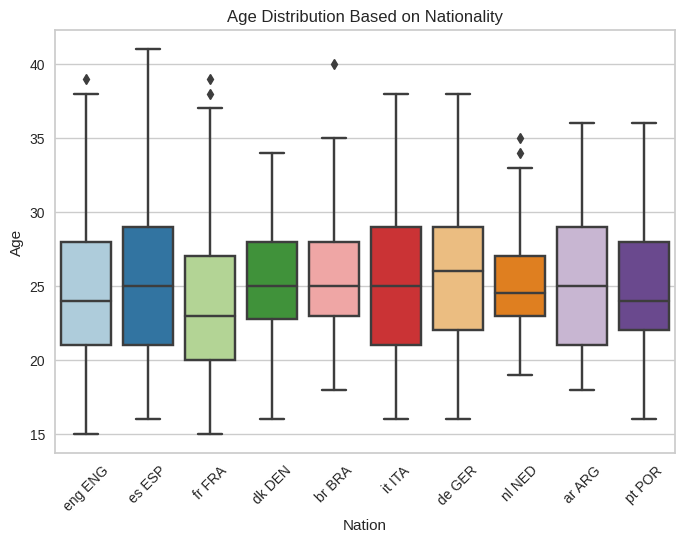

In [18]:
# Visualization of player age distribution based on the top 10 countries with the most players
sns.boxplot(x='Nation', y='Age',
            data=fps[fps['Nation'].isin(top_nations.index)], 
            palette='Paired')
plt.title('Age Distribution Based on Nationality')
plt.xlabel('Nation')
plt.ylabel('Age')
plt.xticks(rotation=45)
plt.show()

# **Data Preprocessing**

## **Handling Missing Values**

In [19]:
# Here I will first drop several rows in the `Nation`, `Age`, and `Born` columns that have missing values.
fps.dropna(subset=['Nation', 'Age', 'Born'], inplace=True)
fps.reset_index(drop=True, inplace=True)

# Then I rechecked the columns.
missing_values = fps.isnull().sum()
more_miss = missing_values[missing_values > 0]
more_miss

GA       2632
Saves    2632
Save%    2638
CS       2632
CS%      2641
PKA      2632
PKsv     2632
dtype: int64

After the drop is performed, the missing value remaining in the goalkeeper statistics will then be filled with the value 0.

In [20]:
fps.fillna(0, inplace=True)
fps.head()

,Player,Nation,Pos,Comp,Age,Squad,Born,MP,Starts,Min,...,Touches,Carries,PrgR,Mis,Dis,CrdY,CrdR,PKwon,PKcon,Recov
0,Max Aarons,eng ENG,DF,eng Premier League,24.0,Bournemouth,2000.0,3,1,86,...,73,41,3,1,0,0,0,0,0,7
1,Max Aarons,eng ENG,"DF,MF",es La Liga,24.0,Valencia,2000.0,4,1,120,...,85,46,10,3,1,2,0,0,0,7
2,Rodrigo Abajas,es ESP,DF,es La Liga,21.0,Valencia,2003.0,1,1,65,...,36,13,3,0,2,1,0,0,0,2
3,James Abankwah,ie IRL,"DF,MF",it Serie A,20.0,Udinese,2004.0,6,0,88,...,65,29,1,1,3,1,0,0,0,7
4,Keyliane Abdallah,fr FRA,FW,fr Ligue 1,18.0,Marseille,2006.0,1,0,3,...,4,1,0,1,0,0,0,0,0,0


## **Handling Duplicate Data**

At this stage, I will handle duplicate data. This data occurs due to the influence of mid-season transfers. Here I adopt from the notebook [Football players visualization](#References).

In [21]:
def player_unify(df):
    """
    This function combines player data that has more than one entry (due to mid-season transfers) into one entry.

    Parameters: 
    df: DataFrame football player stats
    
    References: [Football players visualization](#References)
    """
    unified_players = []

    # Looping based on `player_switch_club`
    for player in player_switch_club:
        player_data = df[df['Player'] == player]
        
        # Merge data based on `basic_info` columns
        unified_entry = {
            'Player': player,
            'Nation': player_data['Nation'].iloc[0],
            'Pos': ','.join(player_data['Pos'].unique()),
            'Squad': '/'.join(player_data['Squad'].unique()),
            'Comp': '/'.join(player_data['Comp'].unique()),
            'Age': player_data['Age'].mean(),
            'Born': player_data['Born'].iloc[0]
        }
        
        # For numeric columns, loop based on `required columns`
        for col in required_columns:
            # Make an exception on the `basic_info` column
            if col not in basic_info:
                # Sum except `Save%` and `CS%` columns which are calculated as averages
                unified_entry[col] = player_data[col].mean() if col in ["Save%", "CS%"] else player_data[col].sum()
        
        unified_players.append(unified_entry)
    
    # Delete player entries based on `player_switch_club`
    df = df[~df['Player'].isin(player_switch_club)]
    
    # Add merged player entries to `unified_players`
    unified_df = pd.DataFrame(unified_players)
    result_df = pd.concat([df, unified_df], ignore_index=True)
    
    return result_df

In [22]:
# Use the `player_unify` function
fps = player_unify(fps)
fps = fps.reset_index()
fps.drop("index", axis=1, inplace=True)
fps.head()

,Player,Nation,Pos,Comp,Age,Squad,Born,MP,Starts,Min,...,Touches,Carries,PrgR,Mis,Dis,CrdY,CrdR,PKwon,PKcon,Recov
0,Rodrigo Abajas,es ESP,DF,es La Liga,21.0,Valencia,2003.0,1,1,65,...,36,13,3,0,2,1,0,0,0,2
1,James Abankwah,ie IRL,"DF,MF",it Serie A,20.0,Udinese,2004.0,6,0,88,...,65,29,1,1,3,1,0,0,0,7
2,Keyliane Abdallah,fr FRA,FW,fr Ligue 1,18.0,Marseille,2006.0,1,0,3,...,4,1,0,1,0,0,0,0,0,0
3,Yunis Abdelhamid,ma MAR,DF,fr Ligue 1,36.0,Saint-Étienne,1987.0,16,11,1033,...,641,322,3,8,3,2,0,0,0,42
4,Himad Abdelli,dz ALG,"MF,FW",fr Ligue 1,24.0,Angers,1999.0,32,32,2842,...,1993,1183,111,55,51,4,0,0,0,193


Then I want to combine several positions into one main position, for example MF, FW positions become MF.

In [23]:
# Here I want to know first what positions are in the `Pos` column.
positions = fps['Pos'].unique().tolist()
positions

['DF',
 'DF,MF',
 'FW',
 'MF,FW',
 'MF',
 'FW,MF',
 'GK',
 'FW,DF',
 'DF,FW',
 'MF,DF',
 'DF,DF,MF',
 'MF,FW,FW',
 'FW,MF,MF',
 'DF,DF,FW',
 'FW,MF,FW',
 'FW,FW,MF',
 'MF,FW,MF',
 'FW,MF,MF,FW',
 'MF,FW,DF',
 'DF,MF,MF,DF',
 'DF,FW,MF,DF',
 'FW,MF,DF,MF',
 'DF,FW,MF',
 'MF,MF,FW',
 'DF,FW,DF',
 'DF,FW,DF,MF',
 'DF,MF,DF',
 'MF,FW,FW,MF',
 'FW,DF,MF',
 'FW,DF,FW',
 'FW,MF,FW,DF',
 'DF,MF,FW',
 'FW,DF,DF,MF']

Then combine several positions into one main position.

In [24]:
# Here I will only select the first 2 strings from each position to determine the main position.
position_dict = {pos: pos[:2] for pos in positions}
df_player_positions = list(fps["Pos"])

position_mapping_players = []
for i in range(len(df_player_positions)):
    position_mapping_players.append(position_dict[df_player_positions[i]])

# Create a new column in the fps dataframe to store the main positions. 
fps["Position Category"] = position_mapping_players
# Added `Position Category` column to `basic_info` list
basic_info.append("Position Category")

# Check `Position Category` column 
position_category = fps["Position Category"].unique().tolist()  
position_category

['DF', 'FW', 'MF', 'GK']

In [25]:
# Here I want to recreate the `position_category` list because what I want is the position sorted from 'FW', 'MF', 'DF', 'GK'
position_category = ["FW", "MF", "DF", "GK"]
position_category

['FW', 'MF', 'DF', 'GK']

## **Feature Normalization (MinMax Scaling)**

In [26]:
# Select the features to be normalized
feature_stats = (
    playing_time_n_appearances +
    attacking_stats +
    defensive_stats +
    passing_n_creativity_stats +
    goalkeeping_stats +
    possession_n_ball_control +
    miscellaneous_stats
)

# Perform normalization using `MinMaxScaler`
scaler = MinMaxScaler()
fps_minmaxscale = scaler.fit_transform(fps[feature_stats])
fps_minmaxscale = pd.DataFrame(fps_minmaxscale, columns = feature_stats).reset_index(drop=True)
left = fps[basic_info].reset_index(drop=True)
fps_minmaxscale = pd.concat([left, fps_minmaxscale], axis=1) # merge back with `basic_info`

fps_minmaxscale.head()

,Player,Nation,Pos,Comp,Age,Squad,Born,Position Category,MP,Starts,...,Touches,Carries,PrgR,Mis,Dis,CrdY,CrdR,PKwon,PKcon,Recov
0,Rodrigo Abajas,es ESP,DF,es La Liga,21.0,Valencia,2003.0,DF,0.000000,0.026316,...,0.009310,0.005419,0.006148,0.000000,0.021277,0.066667,0.0,0.0,0.0,0.007874
1,James Abankwah,ie IRL,"DF,MF",it Serie A,20.0,Udinese,2004.0,DF,0.094340,0.000000,...,0.016809,0.012088,0.002049,0.008547,0.031915,0.066667,0.0,0.0,0.0,0.027559
2,Keyliane Abdallah,fr FRA,FW,fr Ligue 1,18.0,Marseille,2006.0,FW,0.000000,0.000000,...,0.001034,0.000417,0.000000,0.008547,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,Yunis Abdelhamid,ma MAR,DF,fr Ligue 1,36.0,Saint-Étienne,1987.0,DF,0.283019,0.289474,...,0.165762,0.134223,0.006148,0.068376,0.031915,0.133333,0.0,0.0,0.0,0.165354
4,Himad Abdelli,dz ALG,"MF,FW",fr Ligue 1,24.0,Angers,1999.0,MF,0.584906,0.842105,...,0.515387,0.493122,0.227459,0.470085,0.542553,0.266667,0.0,0.0,0.0,0.759843


# **Clustering Model Development**

At this stage I use the K-Means Clustering model. After that at the Feature Selection stage I use PCA analysis after feature selection. As previously mentioned at the beginning, the analysis that I will do in this notebook is to group the roles of players in each position. This analysis is done based on the `position_category` list that was previously created in the position merger. For example, in `position_category[FW]` it will be divided into several clusters based on the results of the analysis, we can assume that the cluster results for `FW` have 3 clusters, so we can assume again that the three clusters are Poacher, Target Man, and Deep-lying Forward. But this is still an assumption, so in this notebook I will do an analysis to find the roles of these players from the results of the clustering analysis. After this I will create a lot of functions because I need to bundle each process and document it well so that each process is clearer.

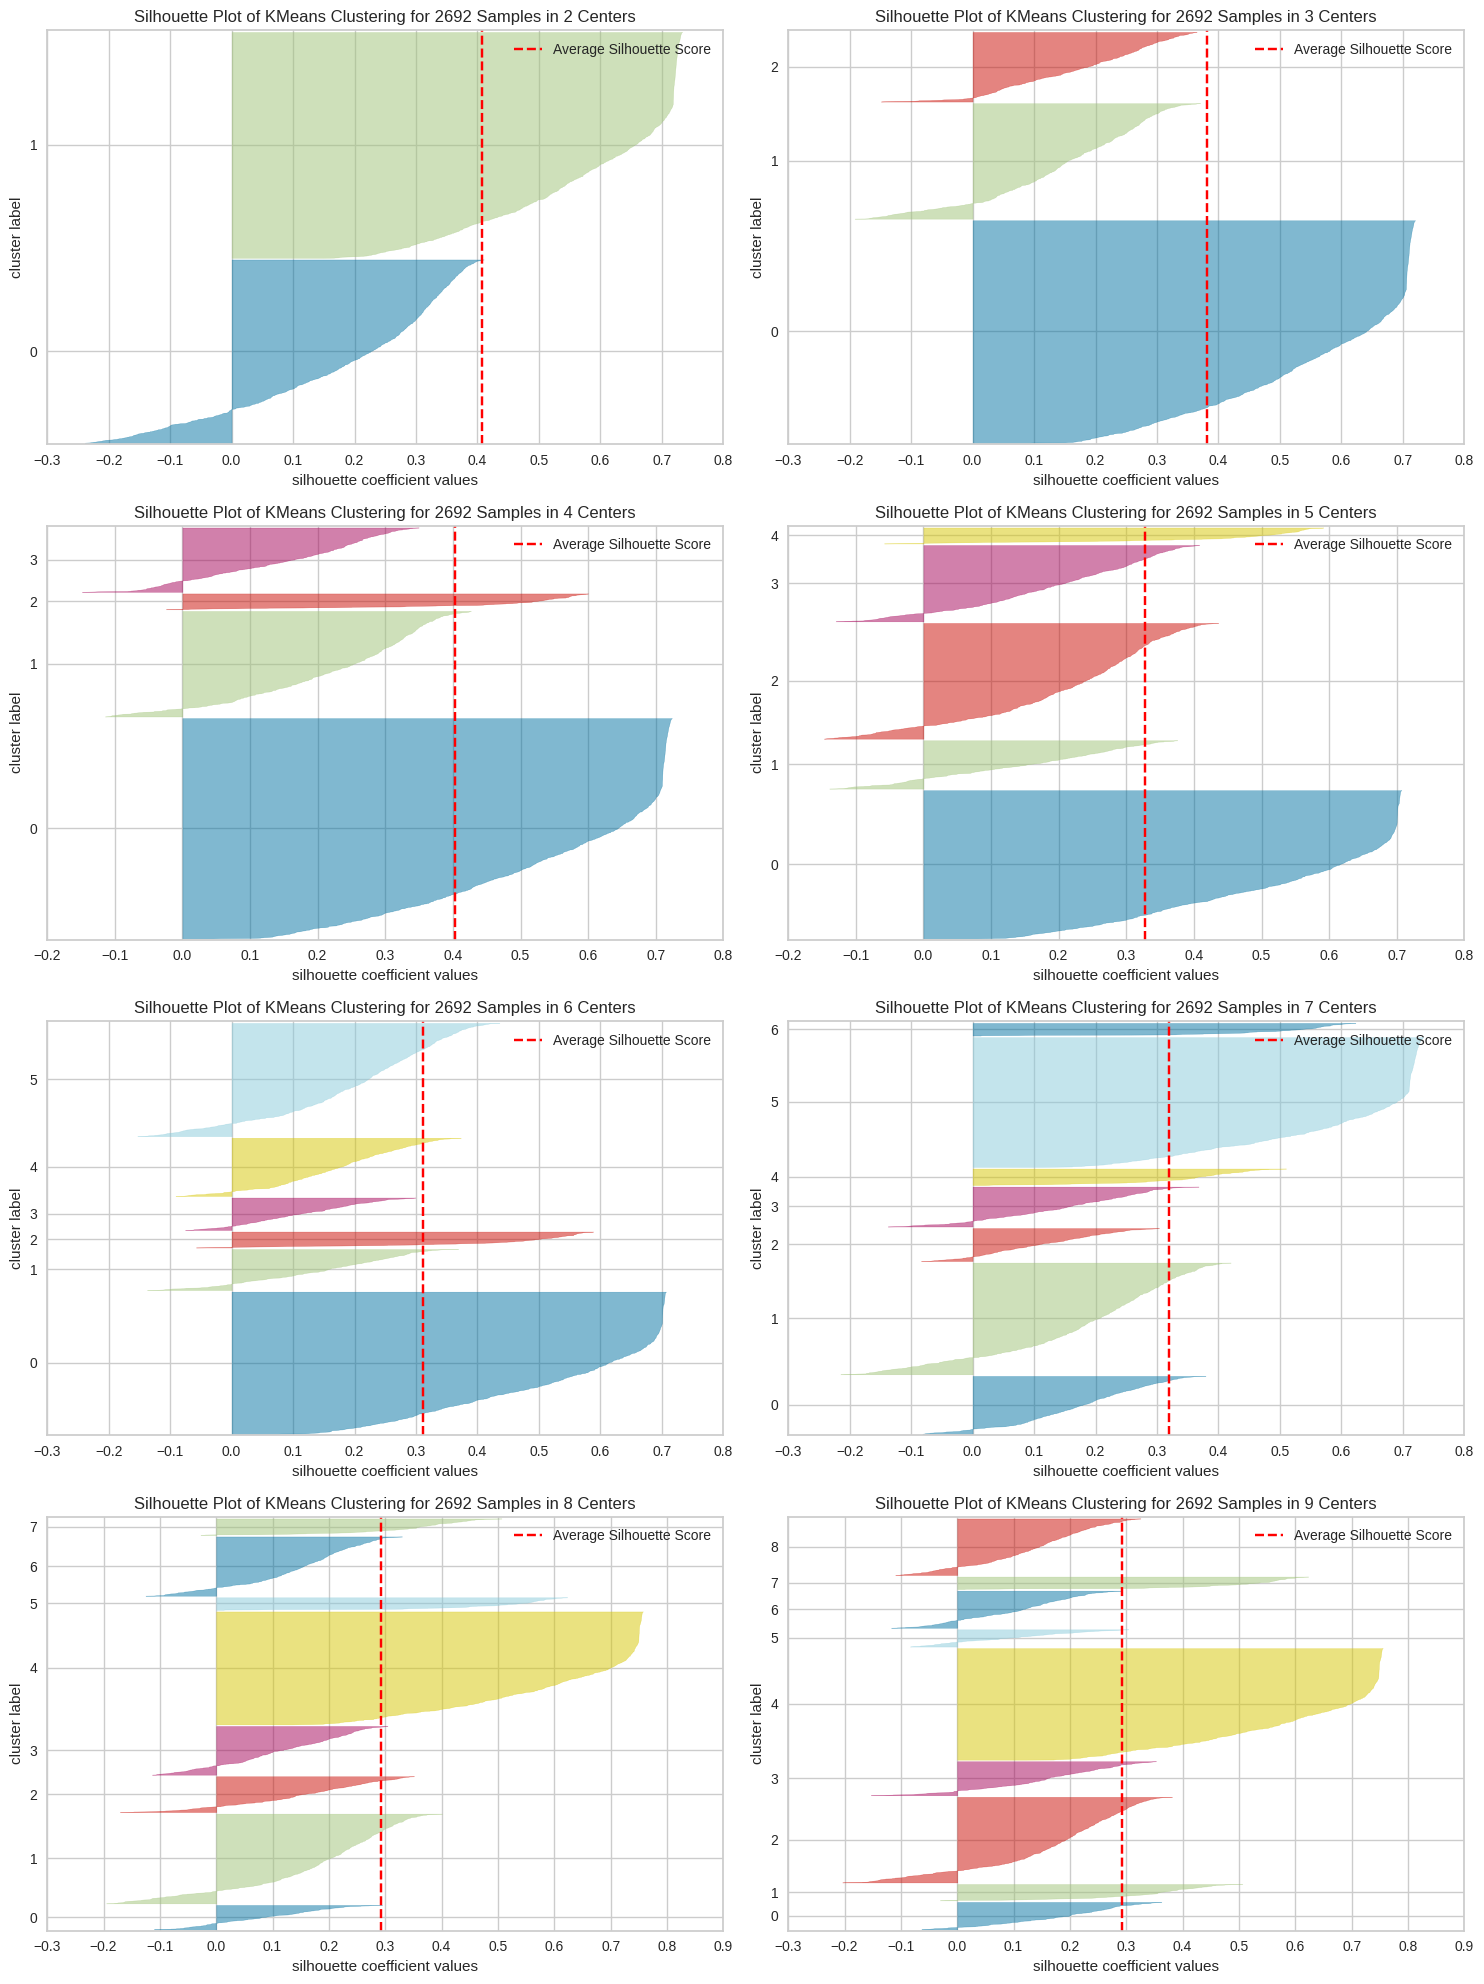

In [27]:
def plot_silhouette(df, features, cluster_range):
    """
    Here I need to visualize the Silhouette Score first to determine the right number of clusters.

    Parameters:
    df: DataFrame containing the data to be analyzed
    features: List of features to be used for clustering
    cluster_range: Range of number of clusters to be tested
    """
    # Identify `n_cols`, `n_rows`, and `axes`
    n_cols = 2
    n_rows = (len(cluster_range) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()  # Use the `flatten` method to ease iteration

    # Looping based on `cluster range`
    for i, n_clusters in enumerate(cluster_range):
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=20, random_state=1)
        visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=axes[i])
        visualizer.fit(df[features])  # Fitting data for visualization
        visualizer.finalize()  # Use the `finalize` method to complete the visualization.

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()  # Use `tight_layout` to avoid overlap
    plt.show()

# Apply `plot_silhouette` function
plot_silhouette(fps_minmaxscale, feature_stats, range(2, 10))

The optimal number of clusters obtained is 2 centers, which is 0.4. Next, I will use 2 clusters to perform `fit_predict` and evaluation on the dataset.

In [28]:
def kmeans_position(df, position, cluster, features):
    """
    This function is to cluster players based on certain positions using KMeans.

    Parameters:
    df: DataFrame containing the data to be analyzed
    position: Position to be analyzed
    cluster: Number of Clusters
    features: Features to be used for clustering
    """
    kmeans = KMeans(n_clusters=cluster, init='k-means++', n_init=20, random_state=1)
    df_position = df[df["Position Category"] == position].copy()
    df_position["Class"] = kmeans.fit_predict(df_position[features])
    return df_position

In [29]:
# Apply the `k means position` function to each position by creating a new dataframe.
striker = kmeans_position(fps_minmaxscale, "FW", 2, feature_stats)
midfield = kmeans_position(fps_minmaxscale, "MF", 2, feature_stats)
defender = kmeans_position(fps_minmaxscale, "DF", 2, feature_stats)
goalkeeper = kmeans_position(fps_minmaxscale, "GK", 2, feature_stats)

In [30]:
def evaluate_kmeans_silhouette(df, features):
    """
    Silhouette Score evaluation from the previous K-Means clustering analysis results.

    Parameters:
    df: List dataframe containing clustering results for each position
    features: Features used for clustering
    """
    silhouette_scores = []
    score = silhouette_score(df[features], df["Class"])
    silhouette_scores.append(score)
        
    return silhouette_scores

In [31]:
# Apply `evaluate_kmeans_silhouette` function for each position
defender_silhouette = evaluate_kmeans_silhouette(defender, feature_stats)
midfield_silhouette = evaluate_kmeans_silhouette(midfield, feature_stats)
striker_silhouette = evaluate_kmeans_silhouette(striker, feature_stats)
goalkeeper_silhouette = evaluate_kmeans_silhouette(goalkeeper, feature_stats)

# Show the results
print("Defender Silhouette Scores:", np.mean(defender_silhouette))
print("Midfield Silhouette Scores:", np.mean(midfield_silhouette))
print("Striker Silhouette Scores:", np.mean(striker_silhouette))
print("Goalkeeper Silhouette Scores:", np.mean(goalkeeper_silhouette))

Defender Silhouette Scores: 0.4500102504954959
Midfield Silhouette Scores: 0.46399590025091025
Striker Silhouette Scores: 0.4953781968421263
Goalkeeper Silhouette Scores: 0.5553710377388079


## **Elbow Method**

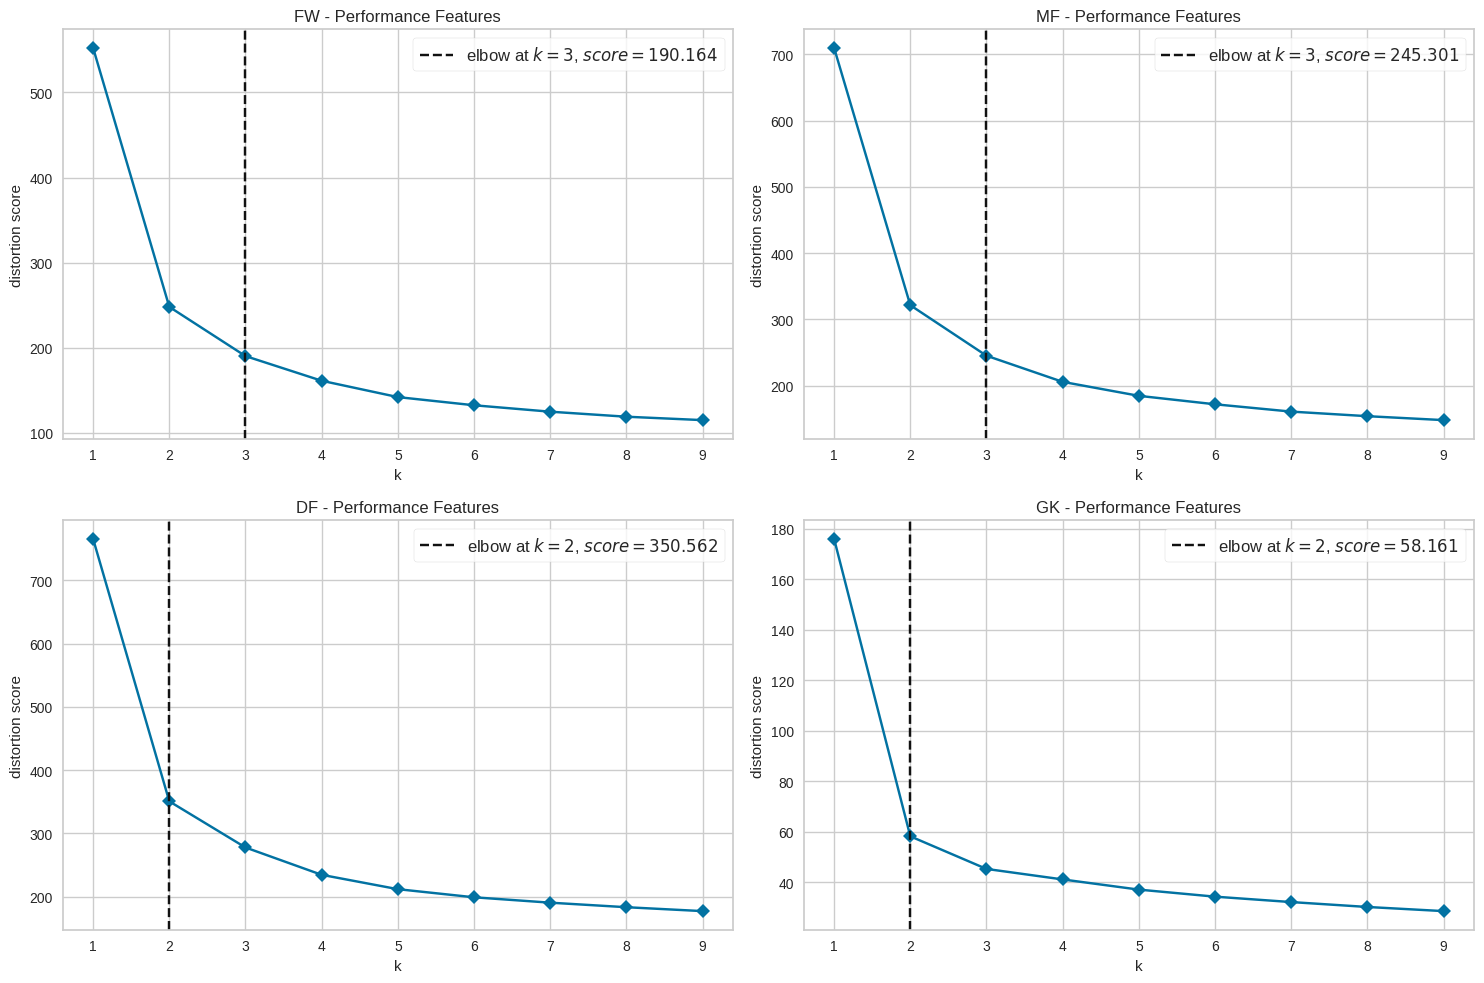

In [32]:
def plot_elbow_with_visualizer(position_list, position_column, df, features):
    """
    Then here the Elbow Method will be used to determine the optimal number of clusters for each position.

    Parameters:
    position_list: List of positions to be analyzed
    position_column: Position column name in dataframe
    df: DataFrame containing the data to be analyzed
    features: Features used for clustering
    """
    # Identify `n_cols`, `n_rows`, and `axes`
    n_cols = 2  
    n_rows = (len(position_list) + n_cols - 1) // n_cols  
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))  
    axes = axes.flatten()  # Use the `flatten` method to ease iteration
    
    # Looping based on `position_list`
    for i, position in enumerate(position_list):
        df_position = df[df[position_column] == position]  # Filter dataframe by position
        
        # Visualize the Elbow Method for each position
        kmeans = KMeans(n_init=20, init='k-means++', random_state=1)
        visualizer = KElbowVisualizer(kmeans, k=(1, 10), timings=False, ax=axes[i])
        visualizer.fit(df_position[features])  # Fitting data for visualization
        visualizer.finalize()  # Use the `finalize` method to complete the visualization.
        axes[i].set_title(f"{position} - Performance Features")

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()  # Use `tight_layout` to avoid overlap
    plt.show()

# Apply `plot_elbow_with_visualizer` function 
plot_elbow_with_visualizer(position_category, "Position Category", fps_minmaxscale, feature_stats)

Elbow Method results for k are obtained: 
- `FW` = 3 
- `MF` = 3 
- `DF` = 2 
- `GK` = 2 

In [33]:
def elbow_position(df, position, cluster, features):
    """
    Evaluation of Elbow Method results using Silhouette Score.

    Parameter:
    df: DataFrame containing the data to be analyzed
    position: Position to be analyzed
    cluster: Number of Clusters
    features: Features to be used for clustering

    Return:
    df_position: DataFrame containing player data with Class column
    silhouette_avg: Silhouette Score for that position
    """
    kmeans = KMeans(n_clusters=cluster, init='k-means++', n_init=20, random_state=1)
    df_position = df[df["Position Category"] == position].copy()
    df_position["Class"] = kmeans.fit_predict(df_position[features])
    silhouette_avg = silhouette_score(df_position[features], df_position["Class"])
    
    return df_position, silhouette_avg

In [34]:
elbow_striker, elbow_striker_silhouette = elbow_position(fps_minmaxscale, 'FW', 3, feature_stats)
elbow_midfield, elbow_midfield_silhouette = elbow_position(fps_minmaxscale, 'MF', 3, feature_stats)
elbow_defender, elbow_defender_silhouette = elbow_position(fps_minmaxscale, 'DF', 2, feature_stats)
elbow_goalkeeper, elbow_goalkeeper_silhouette = elbow_position(fps_minmaxscale, 'GK', 2, feature_stats)

print("Striker Silhouette Scores:", np.mean(elbow_striker_silhouette))
print("Midfield Silhouette Scores:", np.mean(elbow_midfield_silhouette))
print("Defender Silhouette Scores:", np.mean(elbow_defender_silhouette))
print("Goalkeeper Silhouette Scores:", np.mean(elbow_goalkeeper_silhouette))

Striker Silhouette Scores: 0.3686010254151814
Midfield Silhouette Scores: 0.3717418493349124
Defender Silhouette Scores: 0.4500102504954959
Goalkeeper Silhouette Scores: 0.5553710377388079


## **Feature Selection**

Here I want to select features based on statistical relevance to the main position.

In [35]:
# First I need to select the features per feature group first.
attacking_selected = ["Gls", "Ast", "xG", "xA"]
defensive_selected = ["Tkl", "Blocks", "Int", "Clr"]
passing_n_creativity_selected = ["PrgP", "PrgC", "KP", "PPA"]
possession_n_ball_control_selected = ["Touches", "Carries", "PrgR"]

# Then combine those feature groups into one list.
striker_features = (
    attacking_selected + 
    passing_n_creativity_selected +
    possession_n_ball_control_selected
)
midfield_features = (
    attacking_selected + 
    defensive_selected + 
    passing_n_creativity_selected + 
    possession_n_ball_control_selected +
    ["Recov"]  # If there are separate features, enter them as a separate list
)
defender_features = (
    defensive_selected +
    passing_n_creativity_selected +
    possession_n_ball_control_selected +
    ["Recov"]
)
goalkeeper_features = (
    goalkeeping_stats +
    ["Recov", 
    "Ast", "xA", 
    "PrgP", "Touches",
    "Clr", "Blocks"]  # As here there are several separate features, so a separate list has been created.
)

# After that combine all the features
combined_features = (
    striker_features +
    midfield_features +
    defender_features +
    goalkeeper_features
)

In [36]:
def weight_and_scale_features(df, features):
    """
    These features are then weighted first here.
    This weighting is done by multiplying each feature by the `Min` feature.
    After that, MinMax scaling is done again to normalize the features.
    The function of weighting is to standardize the features based on minutes played.

    Parameters:
    df: DataFrame containing the data to be analyzed
    features: Features to be used for weighting and normalization
    """
    weighted_df = df.copy()
    
    # Looping `features` is then multiplied by `Min` feature for weighting.
    for feature in features:
        if feature in df.columns:
            min_value = df['Min'].values.reshape(-1, 1)
            # Use the previously copied `weighted_df`, then multiply it by the `Min` feature.
            weighted_df[feature] = df[feature].values.reshape(-1, 1) * min_value
    
    # Perform MinMax scaling for already weighted features
    scaler = MinMaxScaler()
    weighted_df[features] = scaler.fit_transform(weighted_df[features])

    # Clean up the dataframe and rejoin it with `basic_info`
    weighted_df = pd.DataFrame(weighted_df[features], columns=features).reset_index(drop=True)
    left = df[basic_info].reset_index(drop=True)
    weighted_df = pd.concat([left, weighted_df], axis=1)
    weighted_df = weighted_df.loc[:, ~weighted_df.columns.duplicated()]
    
    return weighted_df

# Apply `weight_and_scale_features` function
fps_weighted = weight_and_scale_features(fps_minmaxscale, combined_features)
fps_weighted.head()

,Player,Nation,Pos,Comp,Age,Squad,Born,Position Category,Gls,Ast,...,Int,Clr,Recov,GA,Saves,Save%,CS,CS%,PKA,PKsv
0,Rodrigo Abajas,es ESP,DF,es La Liga,21.0,Valencia,2003.0,DF,0.000000,0.000000,...,0.000304,0.000000,0.000167,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,James Abankwah,ie IRL,"DF,MF",it Serie A,20.0,Udinese,2004.0,DF,0.000000,0.000000,...,0.000413,0.000322,0.000794,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Keyliane Abdallah,fr FRA,FW,fr Ligue 1,18.0,Marseille,2006.0,FW,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Yunis Abdelhamid,ma MAR,DF,fr Ligue 1,36.0,Saint-Étienne,1987.0,DF,0.000000,0.000000,...,0.068581,0.072595,0.056500,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Himad Abdelli,dz ALG,"MF,FW",fr Ligue 1,24.0,Angers,1999.0,MF,0.174419,0.046835,...,0.350621,0.098171,0.714740,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
def plot_feature_selected_elbow(position_list, position_column, df, features_dict):
    """
    After weighting, analyze the Elbow Method first.
    This function combines features into one dictionary based on position.

    Parameters:
    position_list: List of positions to be analyzed
    position_column: Position column name in dataframe
    df: DataFrame containing the data to be analyzed
    features_dict: This dictionary contains positions as keys and relevant features as values
    """
    # Identify `n_cols`, `n_rows`, and `axes`
    n_cols = 2  
    n_rows = (len(position_list) + n_cols - 1) // n_cols  
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))  
    axes = axes.flatten()  # Use the `flatten` method to ease iteration

    # Looping based on `position_list`
    for i, position in enumerate(position_list):
        df_position = df[df[position_column] == position]  # Filter dataframe by position
        features = features_dict[position]  # Get features by position
        
        # Visualize the Elbow Method for each position
        kmeans = KMeans(n_init=20, init='k-means++', random_state=1)
        visualizer = KElbowVisualizer(kmeans, k=(1, 10), timings=False, ax=axes[i])
        visualizer.fit(df_position[features])  # Fitting data for visualization
        visualizer.finalize()  # Use the `finalize` method to complete the visualization
        axes[i].set_title(f"{position} - Performance Features")

    # Hide unused subplots
    for j in range(len(position_list), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()  # Use `tight_layout` to avoid overlap
    plt.show()

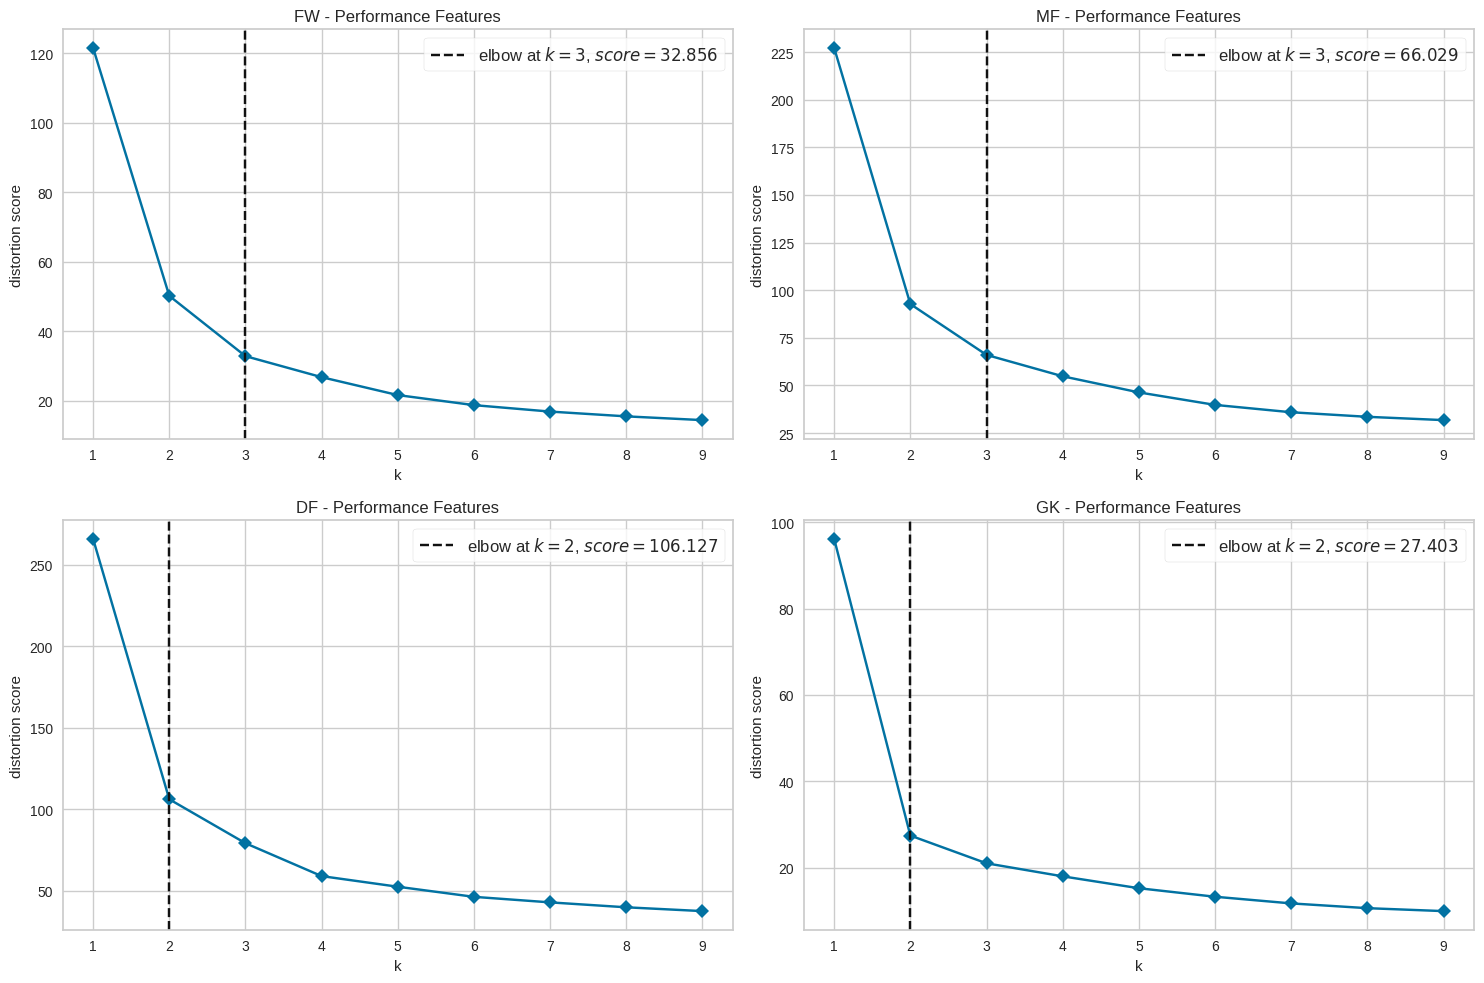

In [38]:
# Create a dictionary first to store features based on position.
features_by_position = {
    "FW": striker_features,
    "MF": midfield_features,
    "DF": defender_features,
    "GK": goalkeeper_features
}

# Apply `plot_feature_selected_elbow` function
plot_feature_selected_elbow(position_category, "Position Category", fps_weighted, features_by_position)

In [39]:
def plot_feature_selected_silhouette(position_list, position_column, df, features_dict, clusters_dict):
    """
    Then do a temporary evaluation by visualizing the Silhouette Score.

    Parameters:
    position_list: List of positions to be analyzed
    position_column: Position column name in dataframe
    df: DataFrame containing the data to be analyzed
    features_dict: This dictionary contains positions as keys and relevant features as values
    clusters_dict: This dictionary contains the position as key and the number of clusters as value
    """
    # Identify `n_cols`, `n_rows`, and `axes`
    n_cols = 2  
    n_rows = (len(position_list) + n_cols - 1) // n_cols  
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))  
    axes = axes.flatten()  # Use the `flatten` method to ease iteration

    # Looping based on `position_list`
    for i, position in enumerate(position_list):
        df_position = df[df[position_column] == position]  # Filter dataframe by position
        features = features_dict[position]  # Get features by position
        n_clusters = clusters_dict[position]  # Get the number of clusters based on position
        
        # Visualize Silhouette Score for each position
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=20, random_state=1)
        visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=axes[i])
        visualizer.fit(df_position[features])  # Fitting data for visualization
        visualizer.finalize()  # Use the `finalize` method to complete the visualization
        axes[i].set_title(f"{position} - Performance Features in {n_clusters} Clusters")

    # Hide unused subplots
    for j in range(len(position_list), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()  # Use `tight_layout` to avoid overlap
    plt.show()

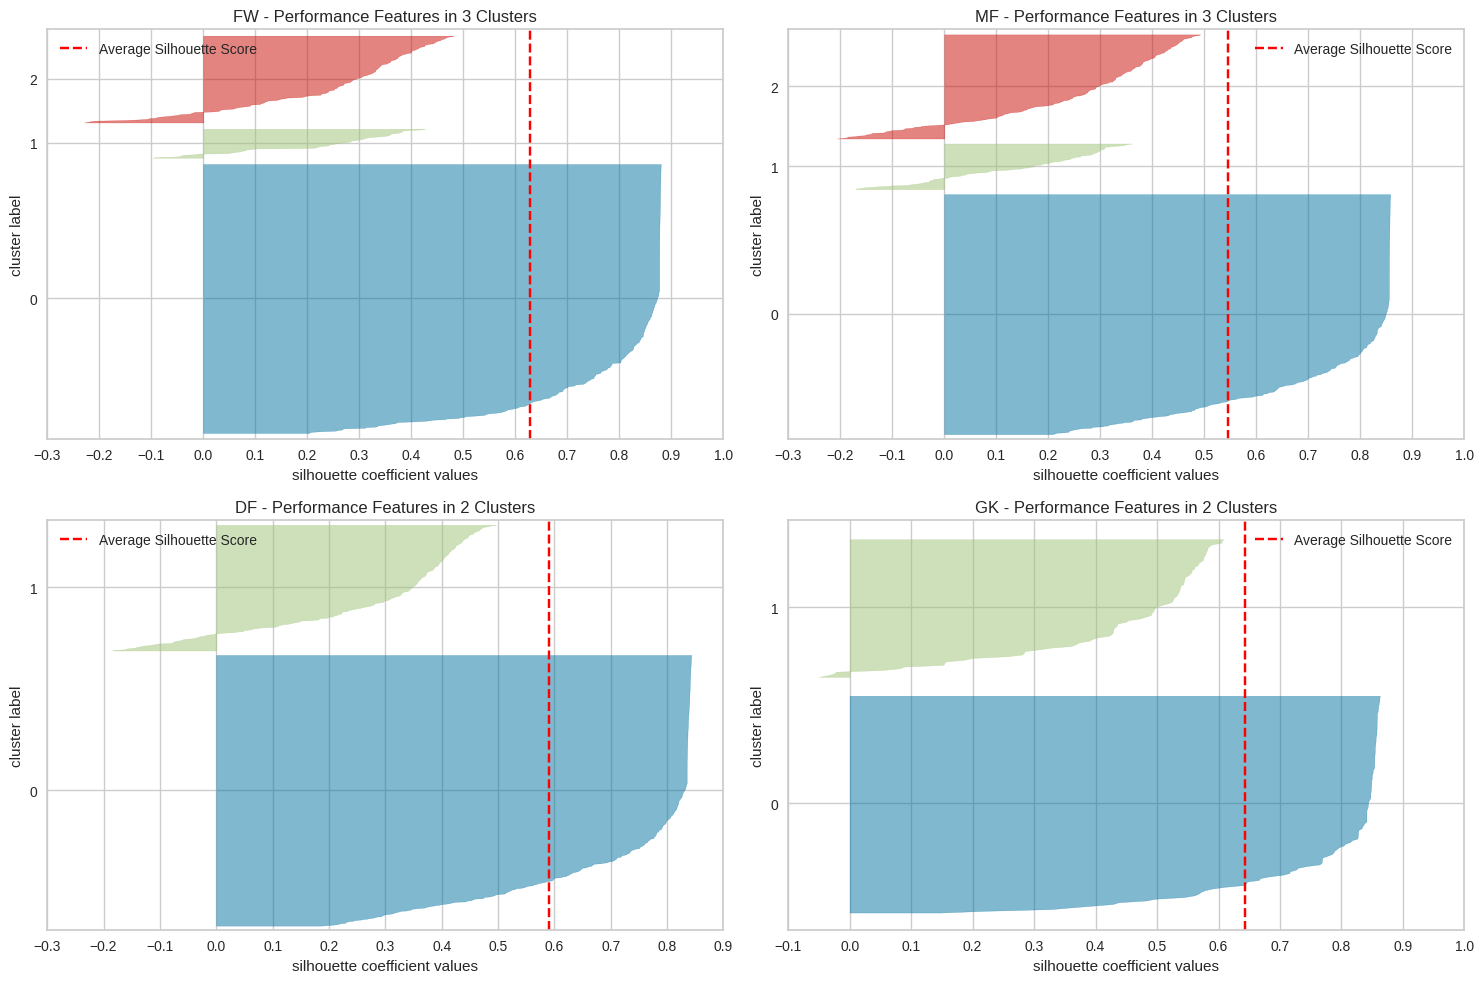

In [40]:
# Create a dictionary first to store the number of clusters based on position
clusters_by_position = {
    "FW": 3,
    "MF": 3,
    "DF": 2,
    "GK": 2
}

# Apply `plot_feature_selected_silhouette` function
plot_feature_selected_silhouette(position_category, "Position Category", fps_weighted, features_by_position, clusters_by_position)

The visualization results of the Silhouette Score above can reach above 0.6. After this, a PCA analysis will be carried out.

## **Principal Component Analysis (PCA)**

Optimal n_components for FW: 3
Optimal n_components for MF: 5
Optimal n_components for DF: 4
Optimal n_components for GK: 3


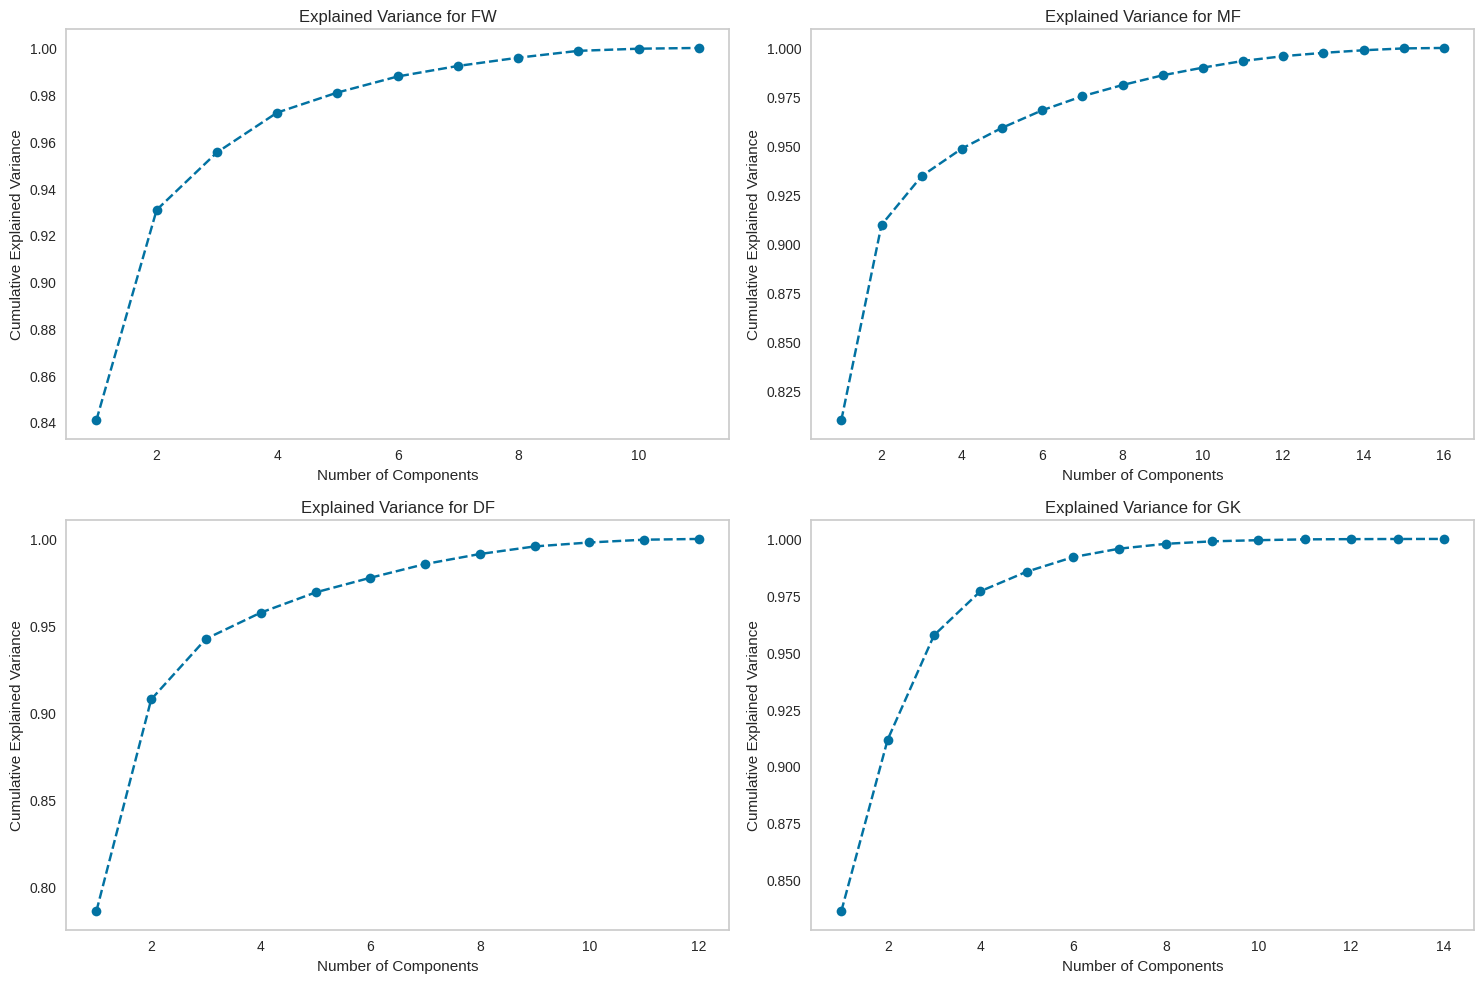

In [41]:
def plot_pca_variance(position_list, position_column, df, features_dict):
    """
    At the beginning of the PCA analysis I want to know the PCA variance first to determine the optimal components.
    By visualizing the cumulative variance of the PCA for each position.
    
    Parameters:
    position_list: List of positions to be analyzed
    position_column: Position column name in dataframe
    df: DataFrame containing the data to be analyzed
    features_dict: This dictionary contains positions as keys and relevant features as values.
    """
    # Identify `n_cols`, `n_rows`, and `axes`
    n_cols = 2  
    n_rows = (len(position_list) + n_cols - 1) // n_cols  
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))  
    axes = axes.flatten()  # Use the `flatten` method to ease iteration
    
    # Looping based on `position_list`
    for i, position in enumerate(position_list):
        df_position = df[df[position_column] == position]  # Filter dataframe by position
        features = features_dict[position]  # Get features by position
    
        # Fitting PCA first
        pca = PCA()
        pca.fit(df_position[features])

        # Define explained variance ratio first
        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_variance = explained_variance_ratio.cumsum()

        # Then plot the cumulative explained variance
        axes[i].plot(
            range(1, len(cumulative_variance) + 1), 
            cumulative_variance, 
            marker='o', linestyle='--'
        )
        axes[i].set_xlabel('Number of Components')
        axes[i].set_ylabel('Cumulative Explained Variance')
        axes[i].set_title(f'Explained Variance for {position}')
        axes[i].grid()

        # Select n_components that have cumulative variance > 95%
        n_components = next(i for i, total in enumerate(cumulative_variance) if total >= 0.95) + 1
        print(f"Optimal n_components for {position}: {n_components}")

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()  # Use `tight_layout` to avoid overlap
    plt.show()

# Apply `plot_pca_variance` function
plot_pca_variance(position_category, "Position Category", fps_weighted, features_by_position)

In [42]:
def fit_transform_pca(df, features_dict, components_dict):
    """
    After getting the optimal number of components, then perform PCA transformation using those components.
    This function returns 2 dictionaries, namely PCA dataframe per position and PCA features per position.
    
    Parameters:
    df: DataFrame containing the data to be analyzed
    features_dict: This dictionary contains positions as keys and relevant features as values.
    components_dict : This dictionary contains positions as keys and the number of PCA components as values.
    
    Returns:
    pca_results: Dictionary contains PCA dataframe per position
    pca_columns: Dictionary contains PCA features per position
    """
    # First create a dictionary to store PCA results and its features
    pca_results = {}
    pca_columns = {}
    positions = sorted(df["Position Category"].unique())  # Get position from dataframe
    
    # Looping position first
    for position in positions:
        # Filter the DataFrame for specific positions
        df_position = df[df["Position Category"] == position].copy()
        # Take the features and number of components 
        features = features_dict[position]
        n_components = components_dict[position]
        
        # Fitting PCA
        pca = PCA(n_components=n_components)
        transformed_data = pca.fit_transform(df_position[features])
        columns = [f'PC{i+1}' for i in range(n_components)]  # Create a feature list of PCA results
        pca_df = pd.DataFrame(transformed_data, columns=columns).reset_index(drop=True)  # Create a dataframe from PCA results
        
        # Combine PCA results with 'basic_info`
        left_position = left[left["Position Category"] == position].reset_index(drop=True)
        final_df = pd.concat([left_position, pca_df], axis=1)
        
        # Save in each dictionary
        pca_results[position] = final_df
        pca_columns[position] = columns
    
    return pca_results, pca_columns

In [43]:
# Create a `components` dictionary according to position first
components = {
    "FW": 3,
    "MF": 5,
    "DF": 4,
    "GK": 3
}

# Apply `fit_transform_pca` function
fps_pca, pca_columns = fit_transform_pca(fps_weighted, features_by_position, components)

# Split PCA dataframe per position
pca_striker = fps_pca["FW"]
pca_midfield = fps_pca["MF"] 
pca_defender = fps_pca["DF"]
pca_goalkeeper = fps_pca["GK"]

# So are the features
striker_columns = pca_columns["FW"]
midfield_columns = pca_columns["MF"]
defender_columns = pca_columns["DF"]
goalkeeper_columns = pca_columns["GK"]

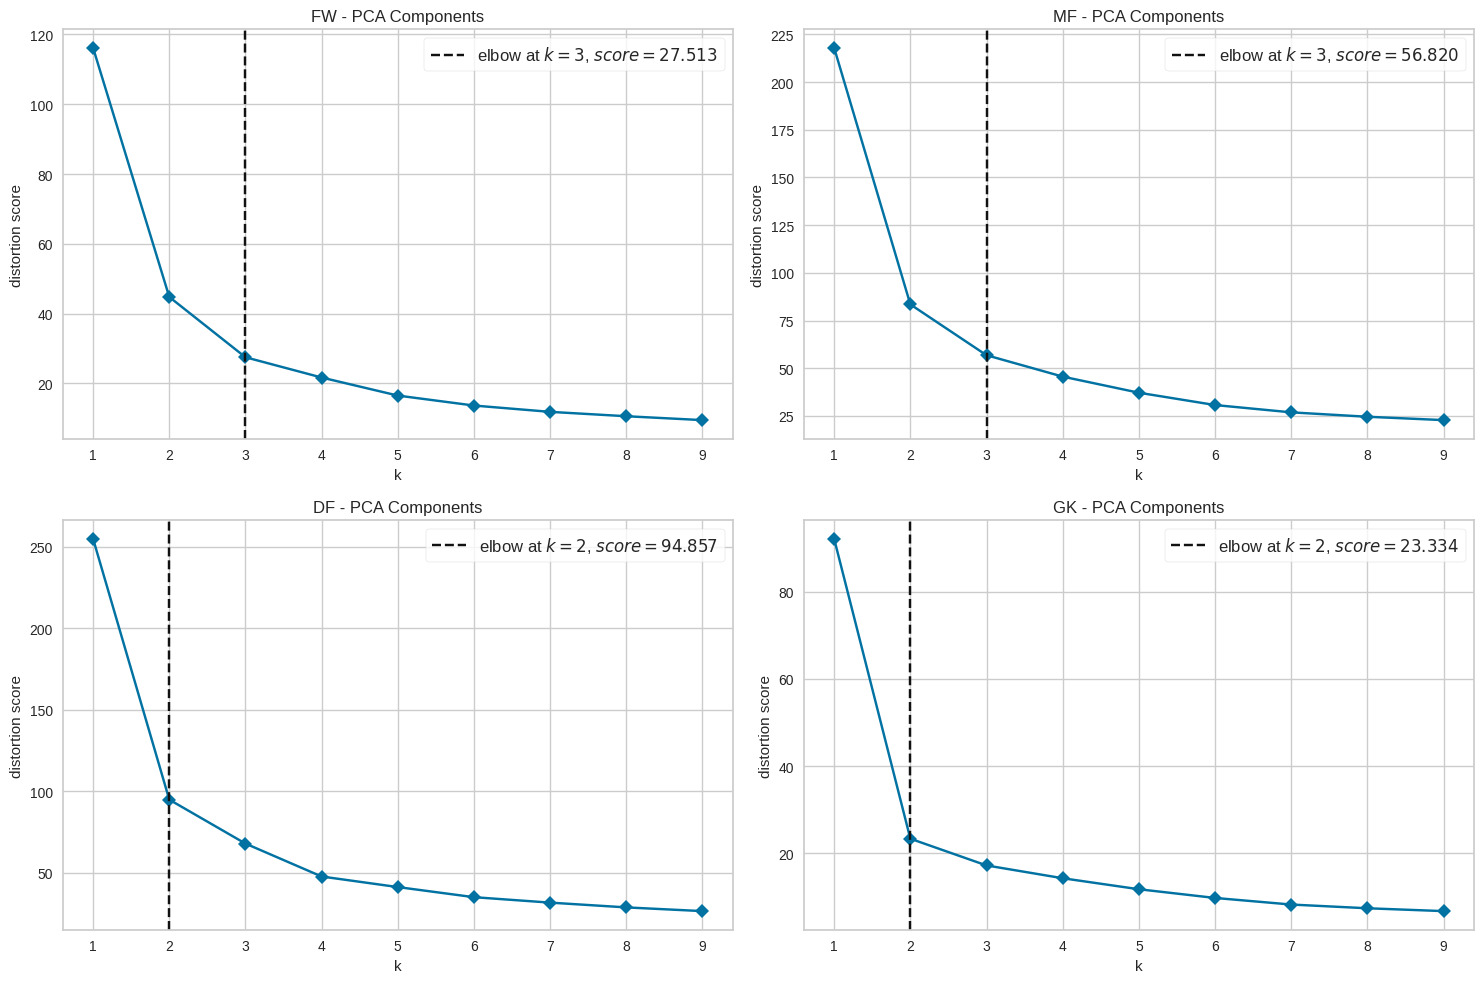

In [44]:
def plot_elbow_pca(position_list, df_dict, features_dict):
    """
    Then analyze the PCA results using the Elbow Method.
    
    Parameters:
    position_list: List of positions to be analyzed
    df_dict : Dictionary dataframe PCA results per position
    features_dict : Dictionary of PCA results features per position
    """
    # Identify `n_cols`, `n_rows`, and `axes`
    n_cols = 2  
    n_rows = (len(position_list) + n_cols - 1) // n_cols  
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))  
    axes = axes.flatten()  # Use the `flatten` method to ease iteration

    # Looping based on `position_list`
    for i, position in enumerate(position_list):
        # Get dataframe and features from dictionary by position
        df_position = df_dict[position]
        features = features_dict[position]
        
        # Visualize Elbow Method 
        kmeans = KMeans(n_init=20, init='k-means++', random_state=1)
        visualizer = KElbowVisualizer(kmeans, k=(1, 10), timings=False, ax=axes[i])
        visualizer.fit(df_position[features])  # Fitting data for visualization
        visualizer.finalize()  # Use the `finalize` method to complete the visualization
        axes[i].set_title(f"{position} - PCA Components")

    # Hide unused subplots
    for j in range(len(position_list), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()  # Use `tight_layout` to avoid overlap
    plt.show()

# Apply `plot_elbow_pca` function
plot_elbow_pca(position_category, fps_pca, pca_columns)

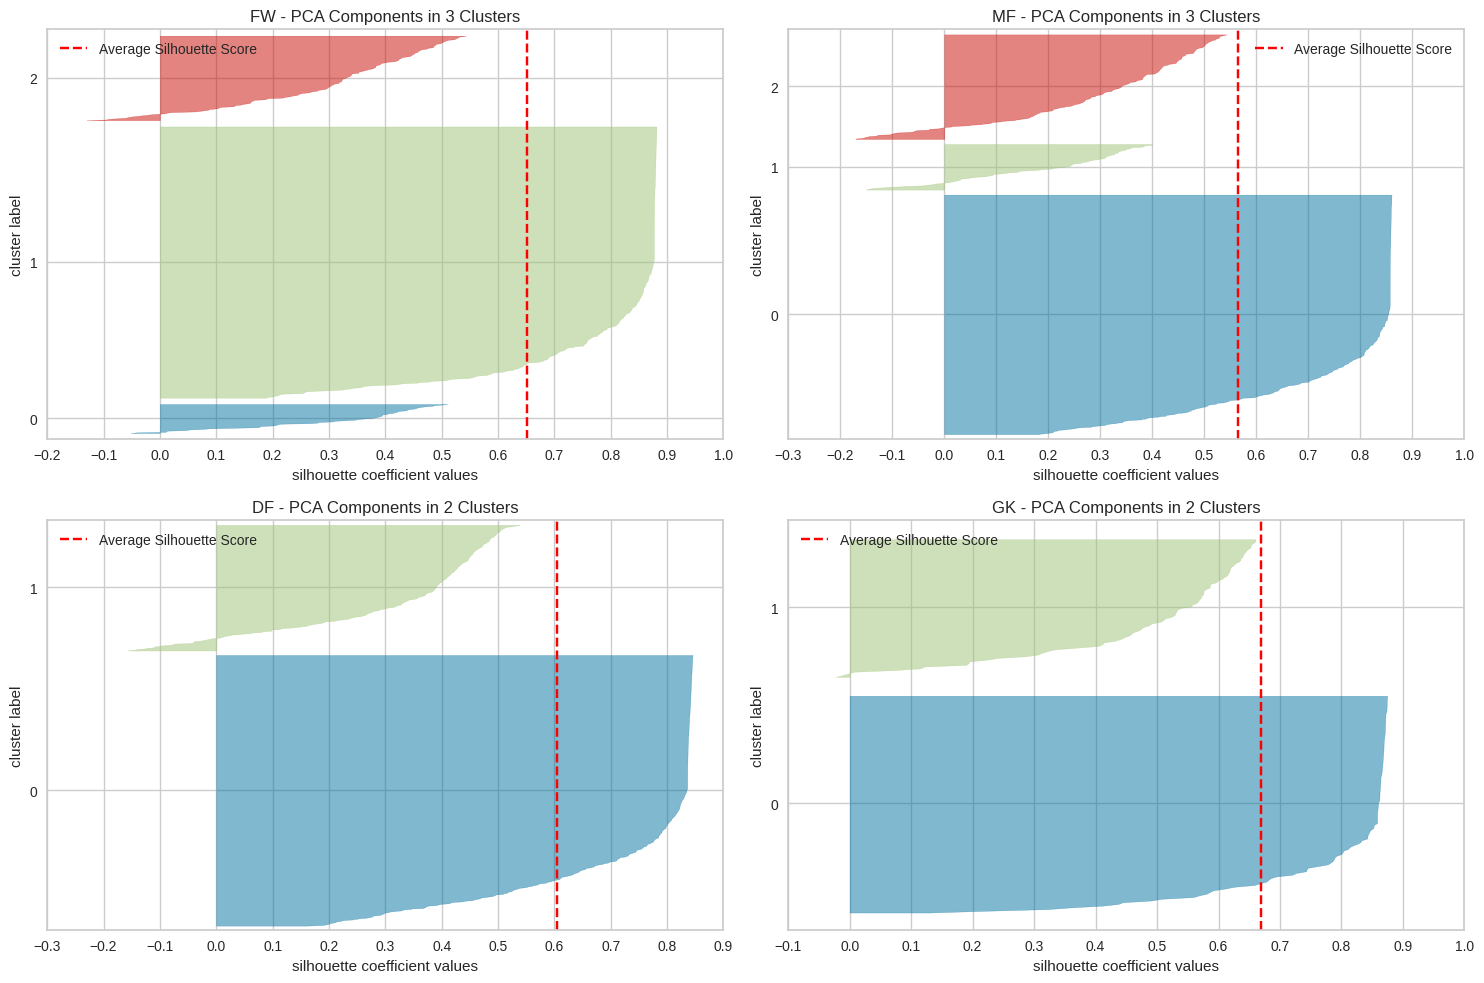

In [45]:
def plot_pca_silhouette(position_list, df_dict, features_dict, clusters_dict):
    """
    Visualize the silhouette score again, here visualize the PCA results to find out the temporary silhouette score.
    
    Parameters:
    position_list: List of positions to be analyzed
    df_dict : Dictionary dataframe PCA results per position
    features_dict : Dictionary of PCA results features per position
    clusters_dict : Dictionary cluster PCA results per position
    """
    # Identify `n_cols`, `n_rows`, and `axes`
    n_cols = 2  
    n_rows = (len(position_list) + n_cols - 1) // n_cols  
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))  
    axes = axes.flatten()  # Use the `flatten` method to ease iteration

    # Looping based on `position_list`
    for i, position in enumerate(position_list):
        # Retrieve dataframe, features, and number of clusters from dictionary based on position
        df_position = df_dict[position]
        features = features_dict[position]
        n_clusters = clusters_dict[position]
        
        # Visualize Silhouette Score
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=20, random_state=1)
        visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=axes[i])
        visualizer.fit(df_position[features])  # Fitting data for visualization
        visualizer.finalize()  # Use the `finalize` method to complete the visualization.
        axes[i].set_title(f"{position} - PCA Components in {n_clusters} Clusters")

    # Hide unused subplots
    for j in range(len(position_list), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()  # Use `tight_layout` to avoid overlap
    plt.show()

# Apply `plot_pca_silhouette` function
plot_pca_silhouette(position_category, fps_pca, pca_columns, clusters_by_position)

Here, the Silhouette Score is close to 0.7, but in the end, it is very difficult to obtain a Silhouette Score of 0.7 due to the type of dataset and the number of features I used, even though Feature Selection and PCA were applied.

In [46]:
def kmeans_pca(position_list, df_dict, features_dict, clusters_dict):
    """
    Then, I perform prediction using KMeans from the PCA analysis data.
    This function returns a dictionary of clustering results per position.
    This function also calculates the Silhouette Score for each position and adds it to the clustering results dataframe.
    
    Parameters:
    position_list: List of positions to be analysed
    df_dict : Dictionary dataframe PCA results per position
    features_dict : Dictionary of PCA results features per position
    clusters_dict : Dictionary cluster PCA results per position
    """
    results = {}  
    
    # Looping based on `position_list`
    for position in position_list:
        # Retrieve dataframe, features, and number of clusters from dictionary based on position
        df_position = df_dict[position]
        features = features_dict[position]
        n_clusters = clusters_dict[position]
        
        # Predict KMeans
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=20, random_state=1)
        df_position["Class"] = kmeans.fit_predict(df_position[features])
        results[position] = df_position  # Save clustering results into a dictionary
        silhouette_avg = silhouette_score(df_position[features], df_position["Class"])
        results[position]["Silhouette Score"] = silhouette_avg  # Add Silhouette Score to the clustering result dataframe
    
    return results

In [47]:
# Perform KMeans clustering on PCA data
cluster_results = kmeans_pca(position_category, fps_pca, pca_columns, clusters_by_position)

print("Striker Silhouette Scores:", np.mean(cluster_results["FW"]["Silhouette Score"]))
print("Midfield Silhouette Scores:", np.mean(cluster_results["MF"]["Silhouette Score"]))
print("Defender Silhouette Scores:", np.mean(cluster_results["DF"]["Silhouette Score"]))
print("Goalkeeper Silhouette Scores:", np.mean(cluster_results["GK"]["Silhouette Score"]))

Striker Silhouette Scores: 0.6507234002484672
Midfield Silhouette Scores: 0.5645113613508284
Defender Silhouette Scores: 0.6048028709935142
Goalkeeper Silhouette Scores: 0.6697250863502527


## **Clustering Results Visualization**

positions: FW
Class: 0
Number of players: 51
-
positions: FW
Class: 1
Number of players: 470
-
positions: FW
Class: 2
Number of players: 147
-


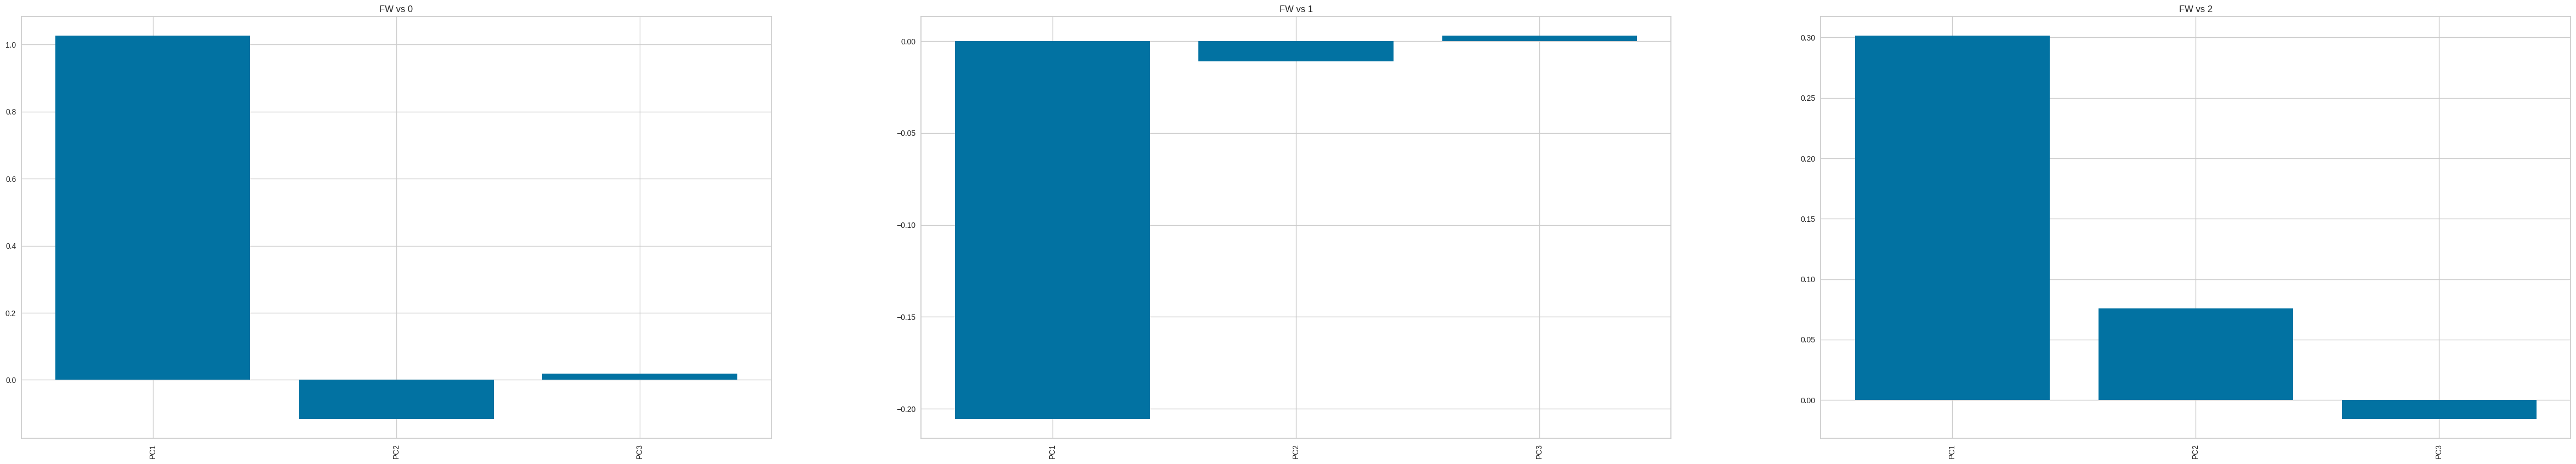

positions: MF
Class: 0
Number of players: 521
-
positions: MF
Class: 1
Number of players: 100
-
positions: MF
Class: 2
Number of players: 228
-


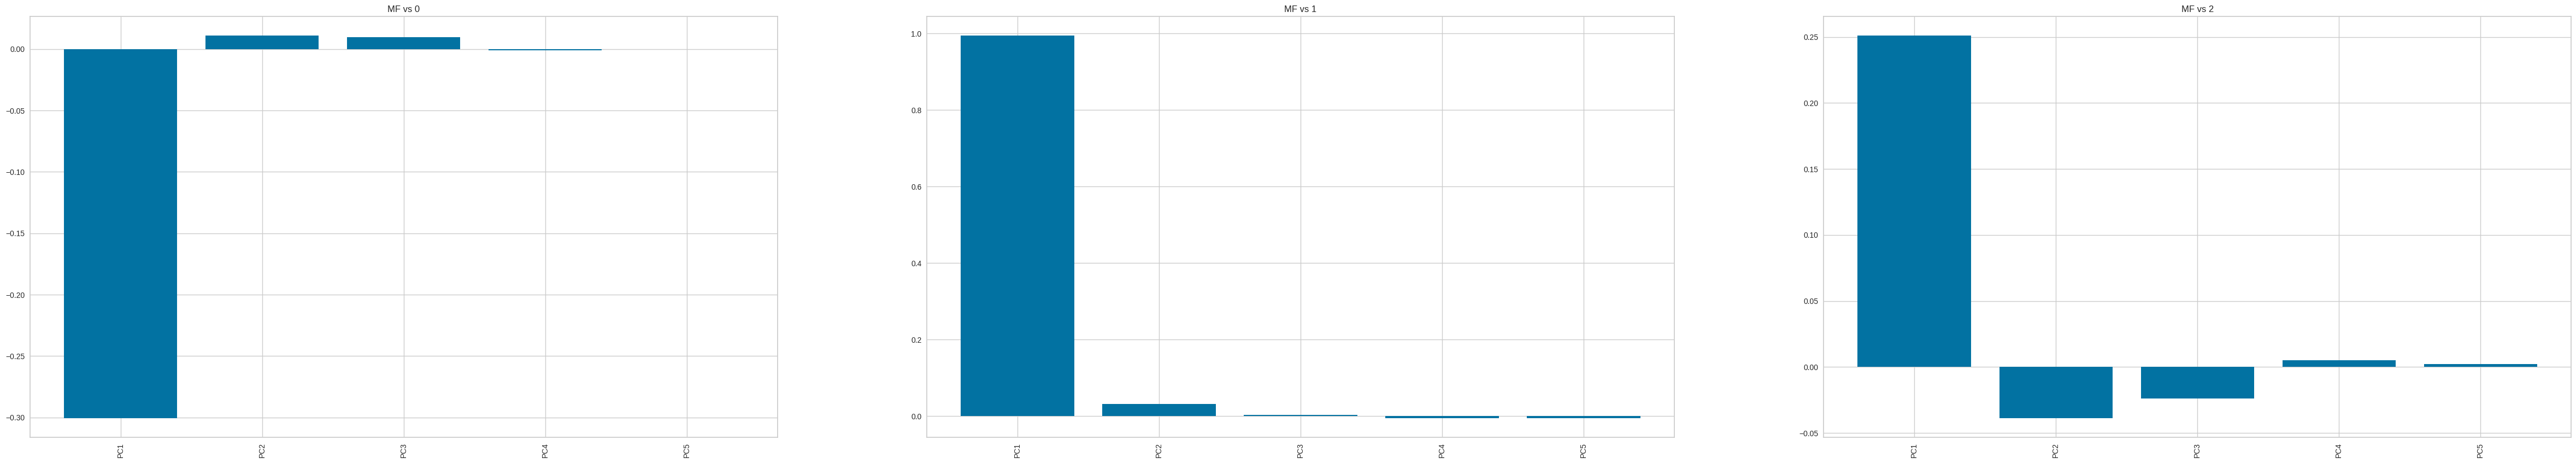

positions: DF
Class: 0
Number of players: 660
-
positions: DF
Class: 1
Number of players: 307
-


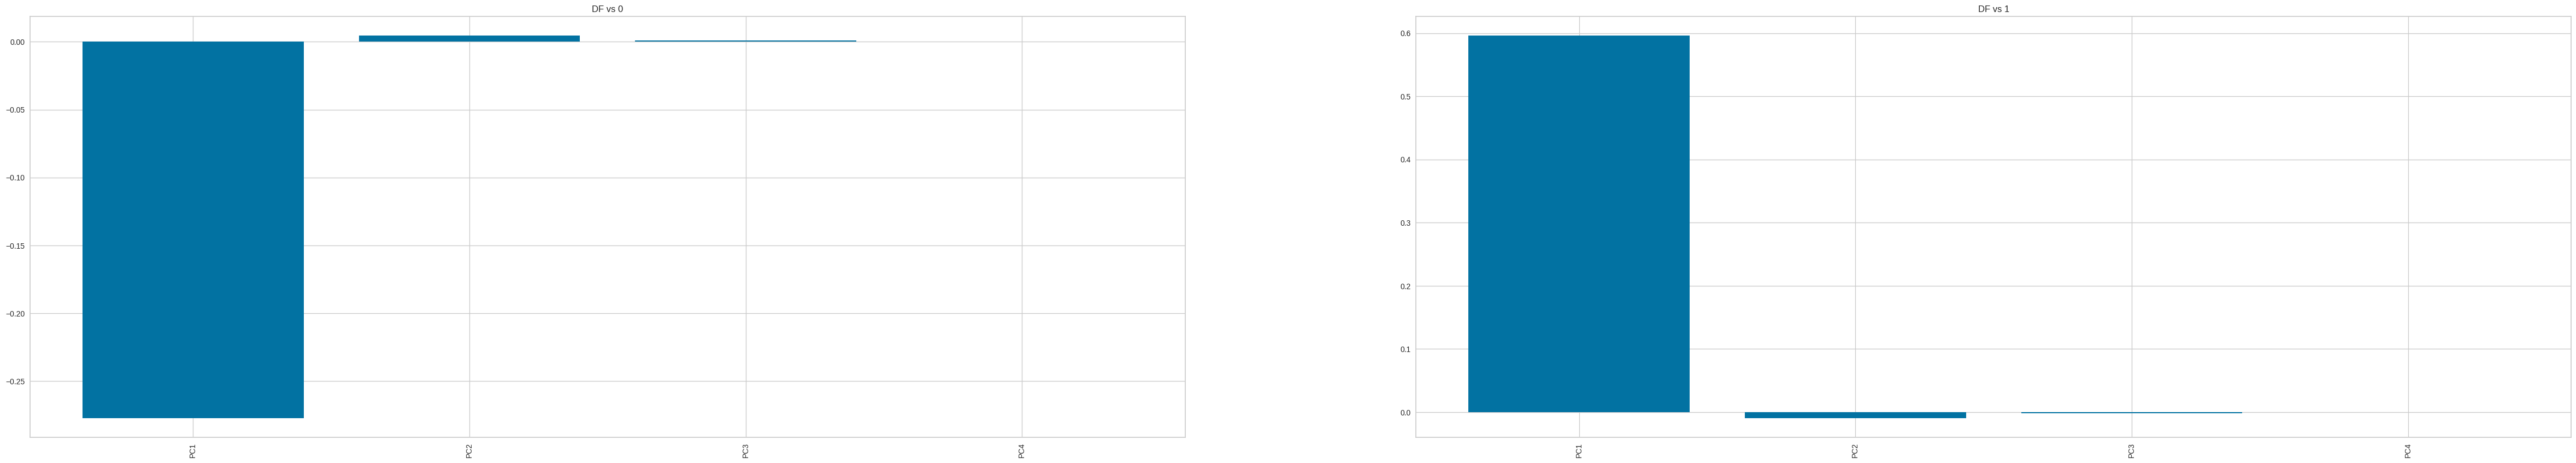

positions: GK
Class: 0
Number of players: 127
-
positions: GK
Class: 1
Number of players: 81
-


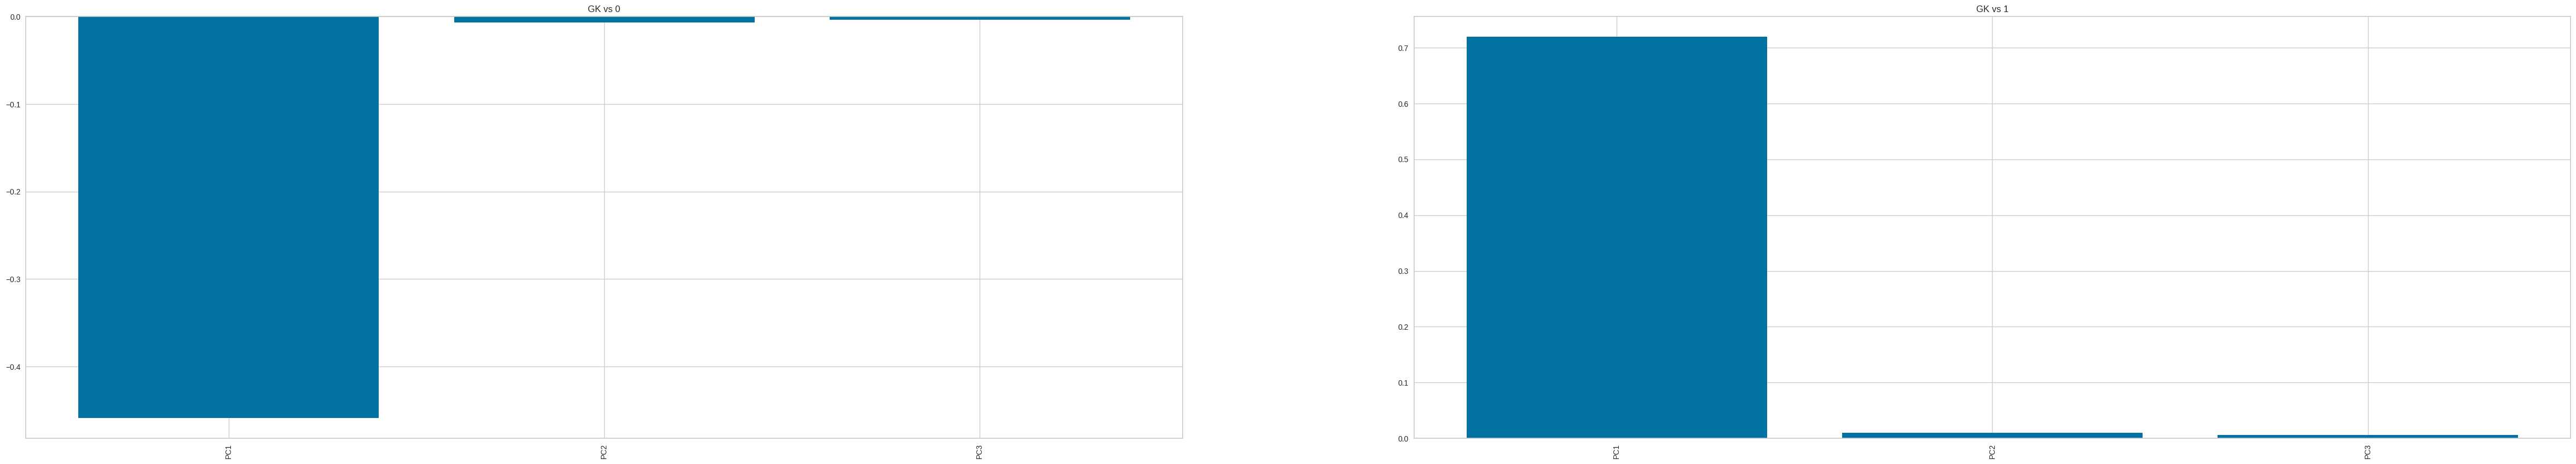

In [48]:
def plot_class(position_list, df_dict, features_dict, clusters_dict):
    '''
    I will do the bar chart visualization first.
    I will adopt the cell from Football players visualization.

    Parameters:
    position_list: List of positions to be analyzed
    df_dict : Dictionary dataframe clustering results per position
    features_dict : Dictionary features clustering results per position
    clusters_dict : Dictionary cluster clustering results per position

    referensi: [Football players visualization](#References)
    '''
    # Looping over `position_list` using enumerate to retrieve the index and position
    for i, position in enumerate(position_list):
        # Retrieve dataframe, features, and number of clusters from dictionary based on position
        df_position = df_dict[position]
        features = features_dict[position]
        n_clusters = clusters_dict[position]

        # Create figures and axes for subplots
        fig, axes = plt.subplots(nrows=1, ncols=n_clusters, figsize=(60, 10))
        
        # Looping based on number of clusters
        for j in range(n_clusters):
            # Take data based on cluster and position, then calculate the average for each feature.
            data = df_position[(df_position["Class"] == j) & (df_position["Position Category"] == position_list[i])][features].mean()
            data_dict = dict(data)  # Then save it in dictionary form
            data = pd.DataFrame.from_dict(data_dict, orient='index', columns=['Mean Value'])  # Create a dataframe with the column name `Mean Value`

            # Visualize a bar chart for each cluster
            axes[j].bar(data.index, data['Mean Value'])
            axes[j].set_xticks(range(len(data)))
            axes[j].set_xticklabels(data.index, rotation=90)
            axes[j].set_title(position_list[i] + " vs " + str(j))
            print("positions: " + position_list[i])
            print("Class: " + str(j))
            print("Number of players: " + str(df_position[(df_position["Class"] == j) & (df_position["Position Category"] == position_list[i])].shape[0]))
            print("-")
        plt.show()

# Apply `plot_class` function
plot_class(position_category, cluster_results, pca_columns, clusters_by_position)

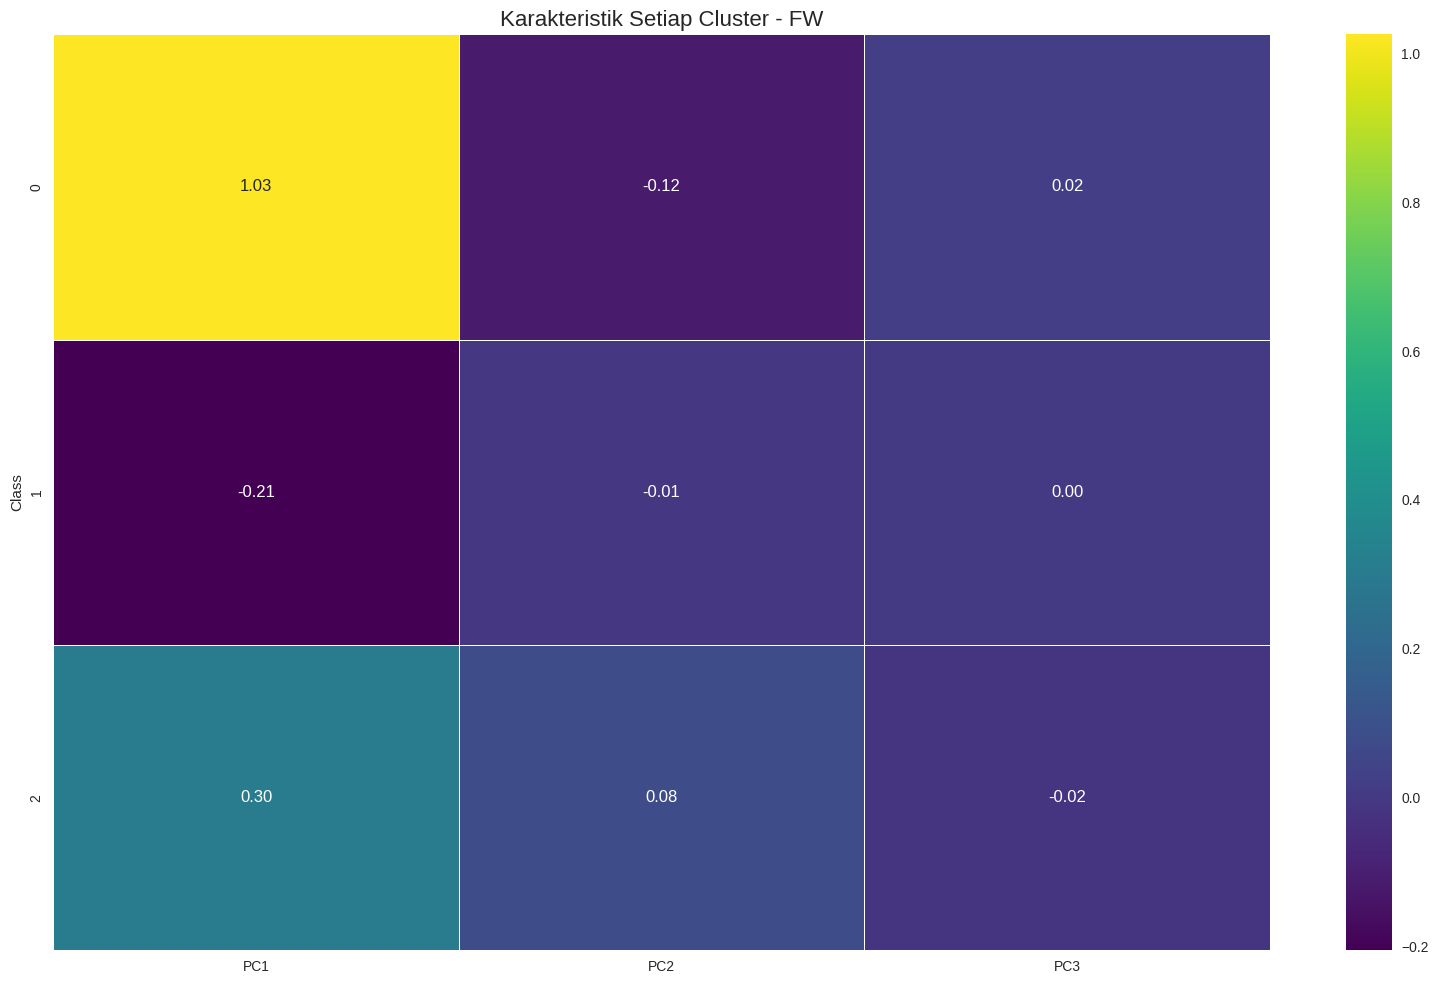

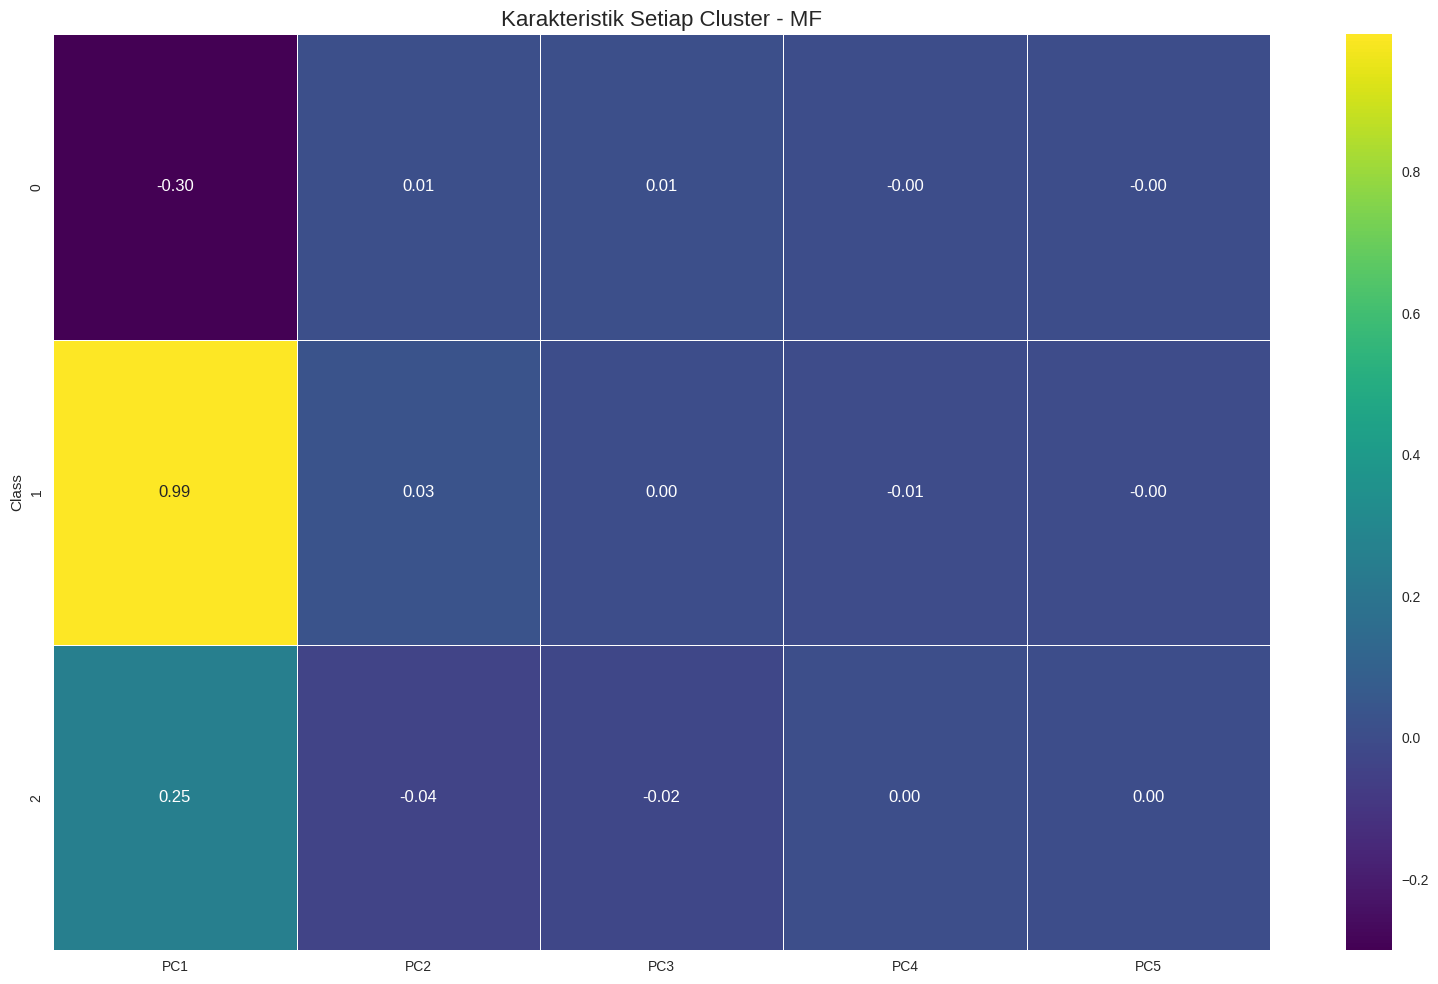

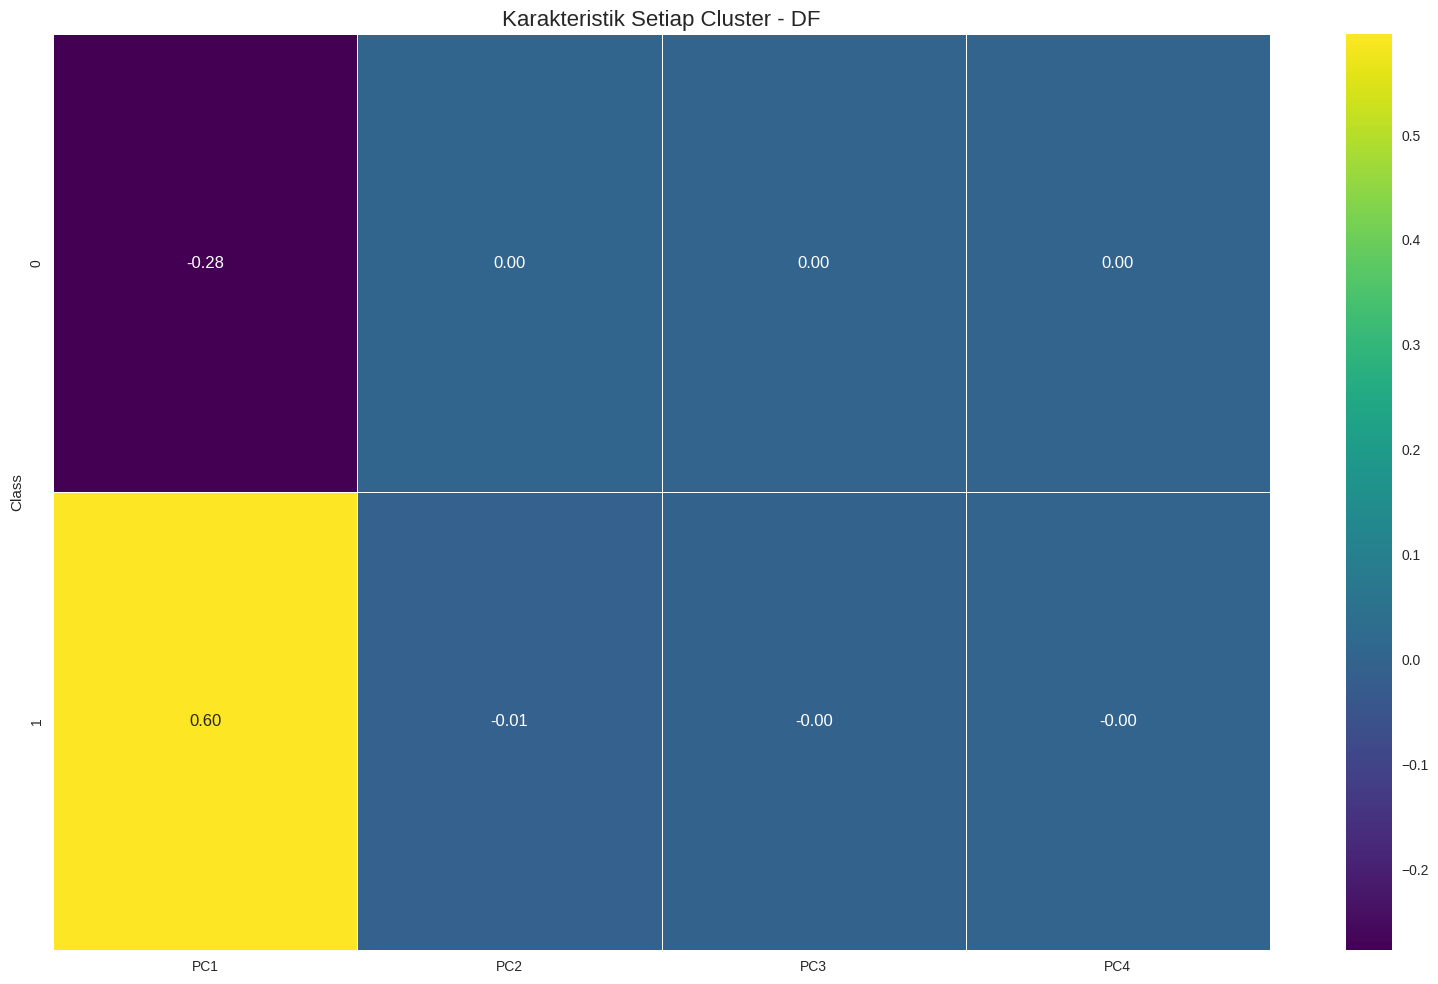

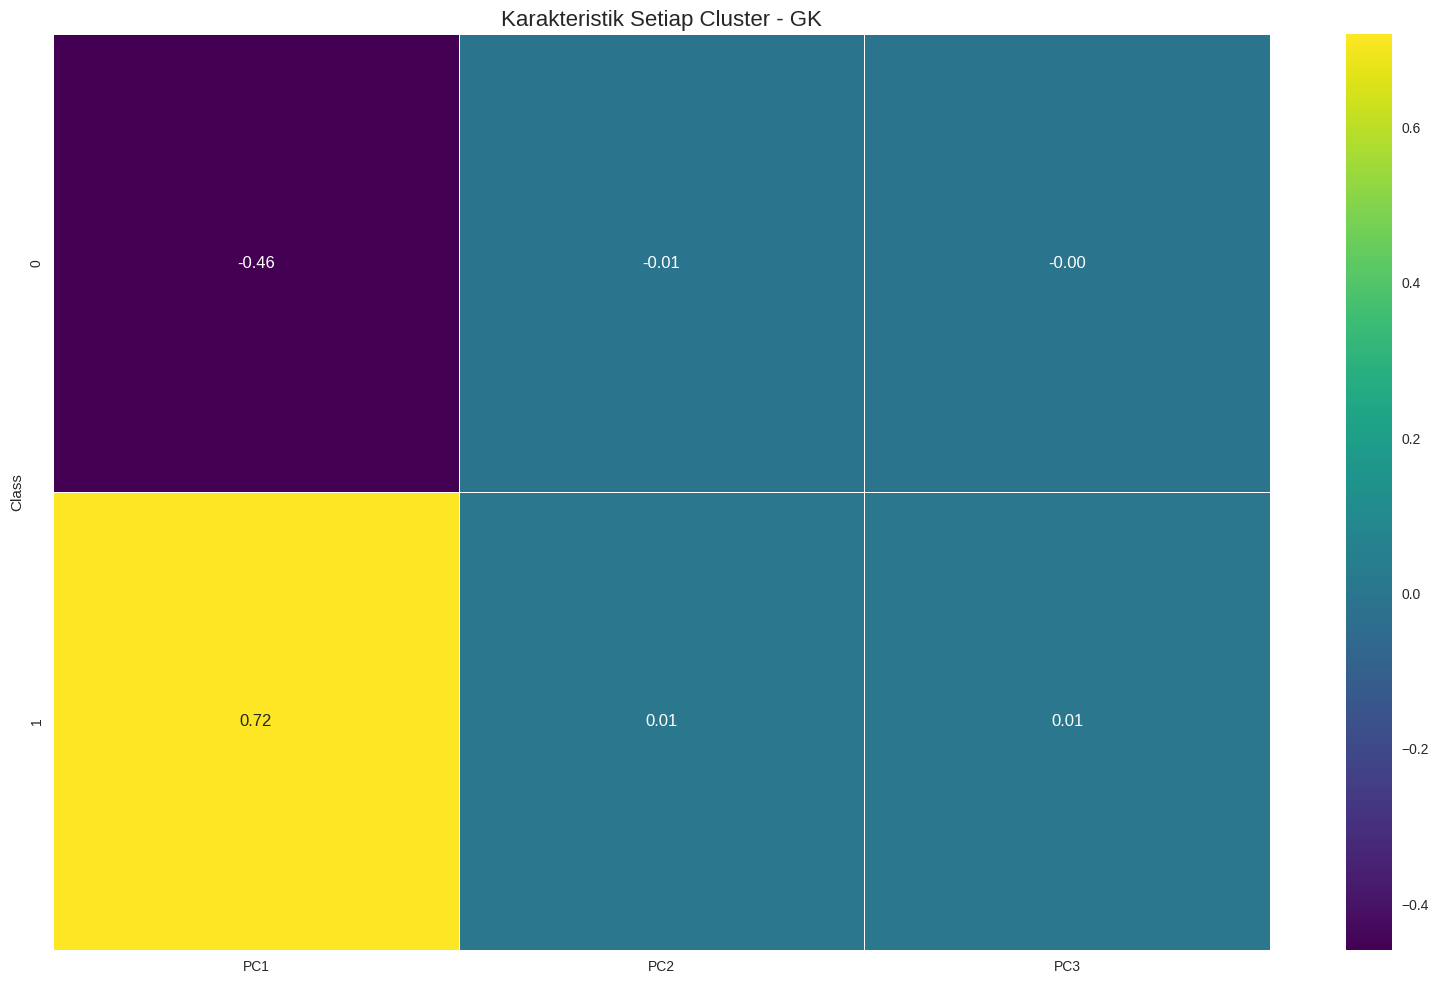

In [49]:
def plot_heatmap(position_list, df_dict, features_dict):
    """
    Then visualize the heatmap.

    Parameters:
    position_list: List of positions to be analyzed
    df_dict : Dictionary dataframe clustering results per position
    features_dict : Dictionary features clustering results per position
    """
    # Looping based on `position_list`
    for position in position_list:
        # Get dataframe and features from dictionary by position
        df_position = df_dict[position]
        features = features_dict[position]
        
        # Take clusters using `groupby` and calculate the mean for each feature
        cluster_analysis = df_position.groupby('Class')[features].mean()
        
        # Plot the heatmap
        plt.figure(figsize=(16, 10))
        sns.heatmap(cluster_analysis, annot=True, cmap='viridis', fmt='.2f', linewidths=.5)  # Using `cluster analysis` to plot heatmaps
        plt.title('Karakteristik Setiap Cluster - ' + position, fontsize=16)
        plt.tight_layout()  # Use `tight_layout` to avoid overlap
        plt.show()

# Apply `plot_heatmap` function
plot_heatmap(position_category, cluster_results, pca_columns)

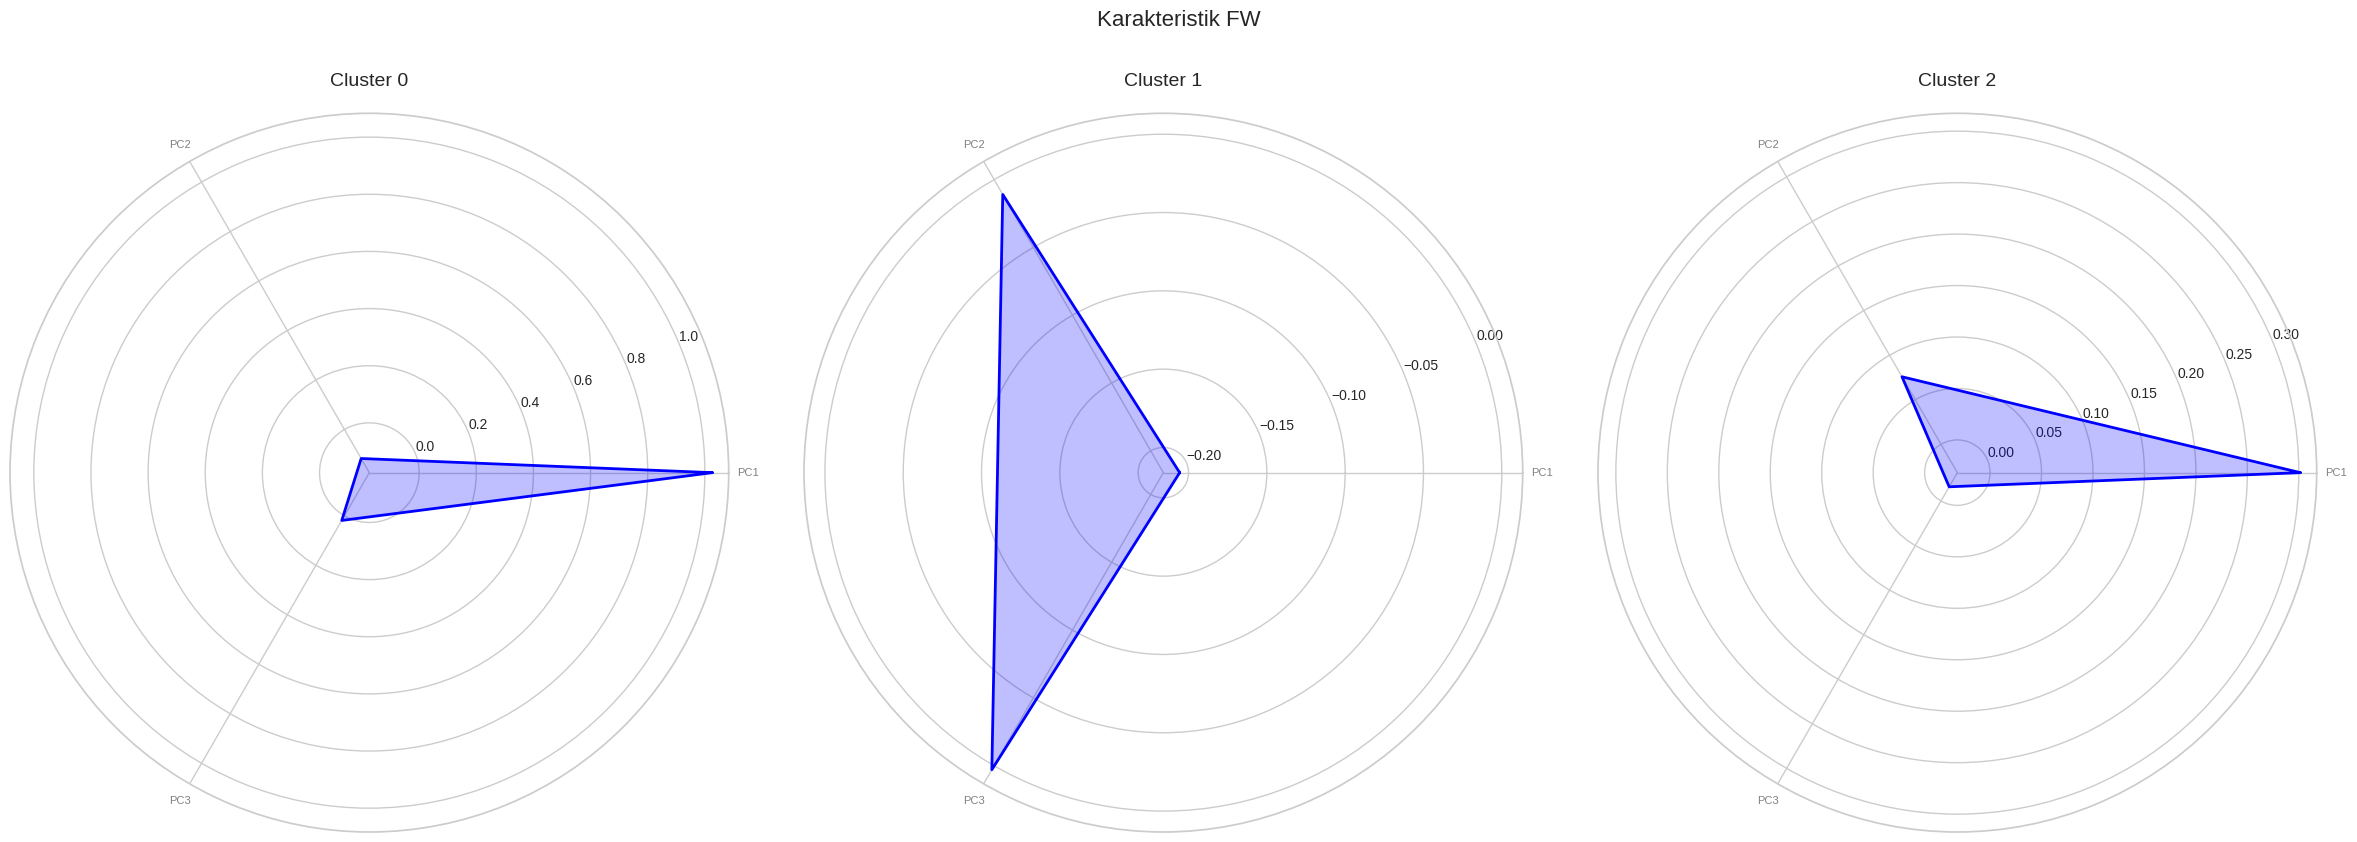

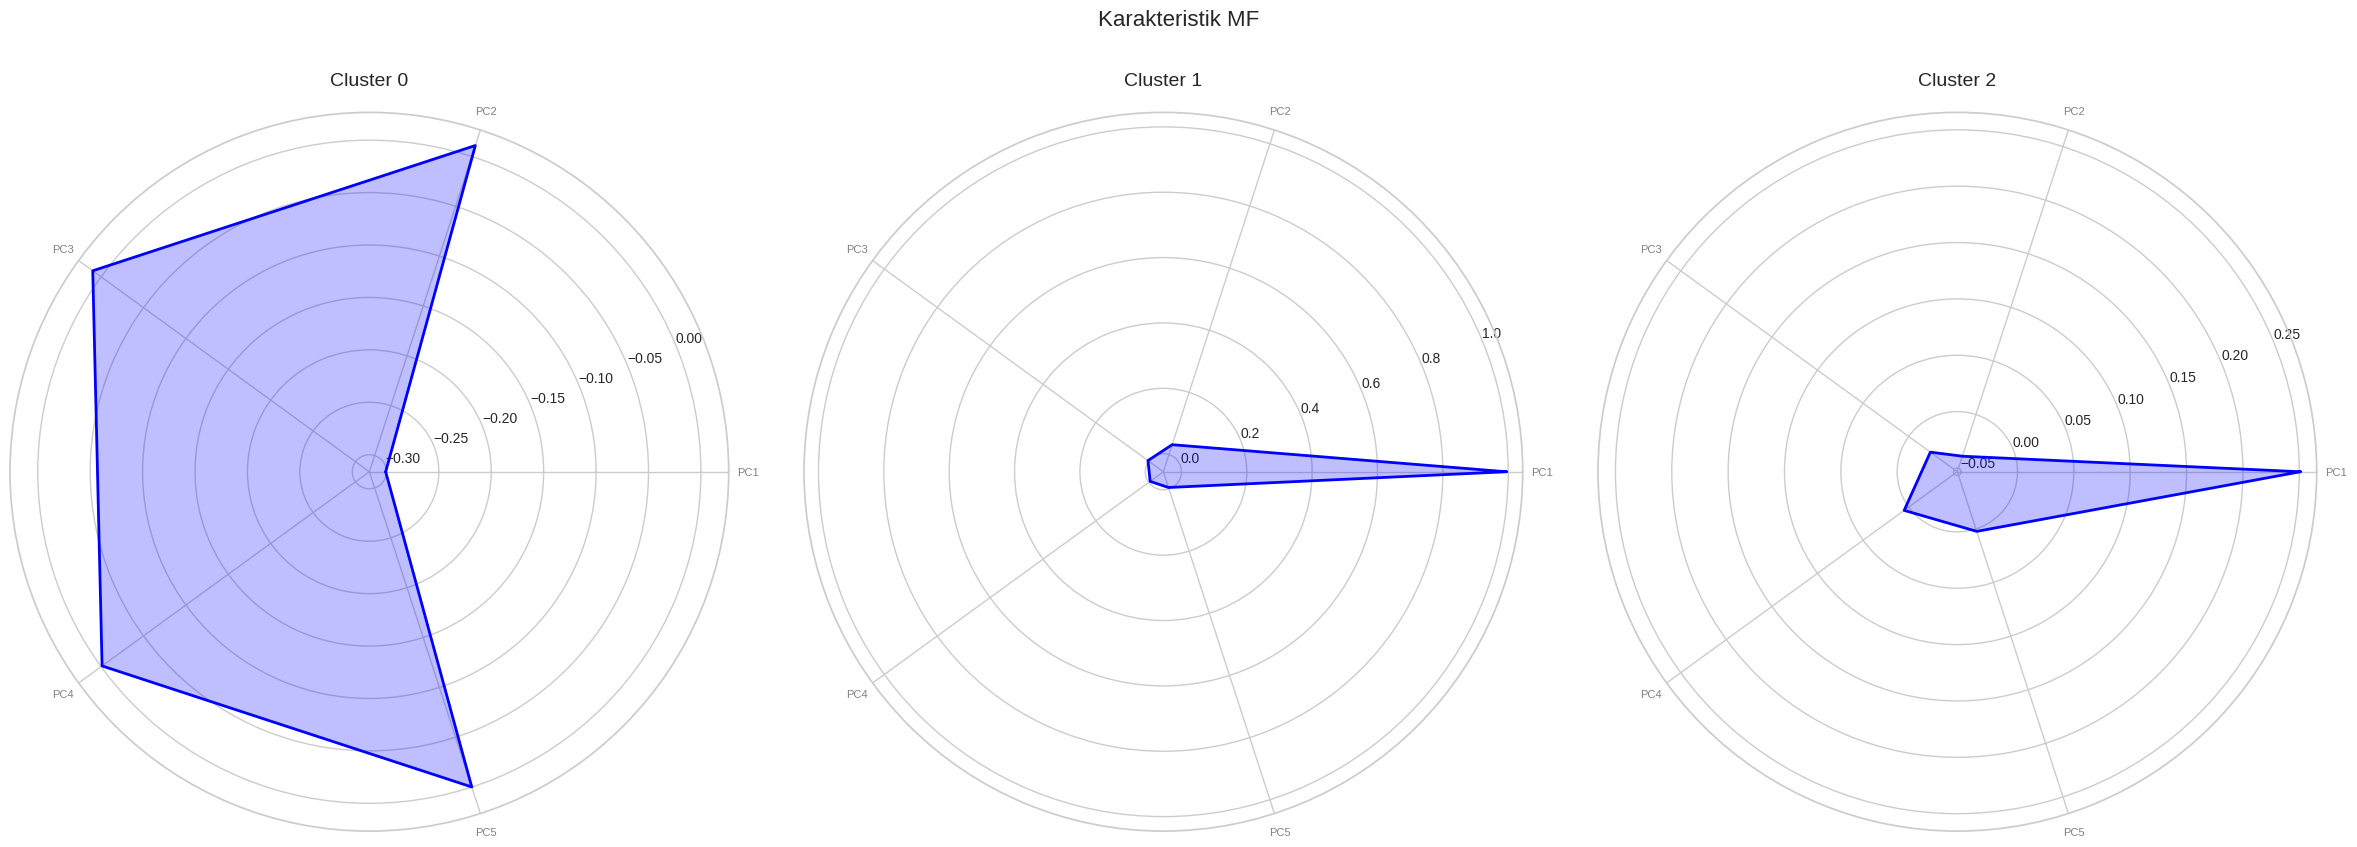

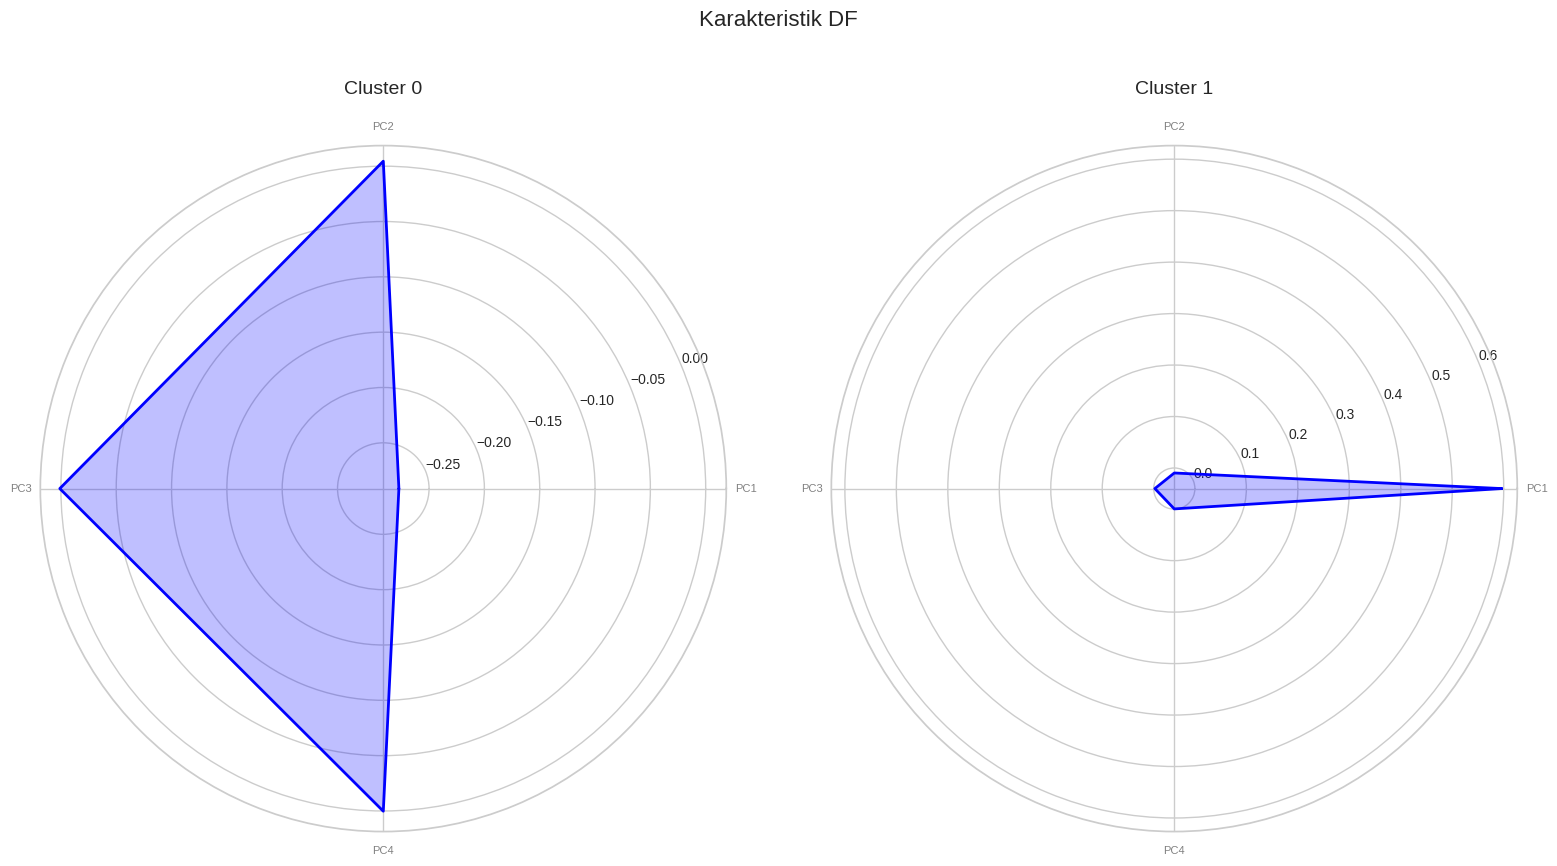

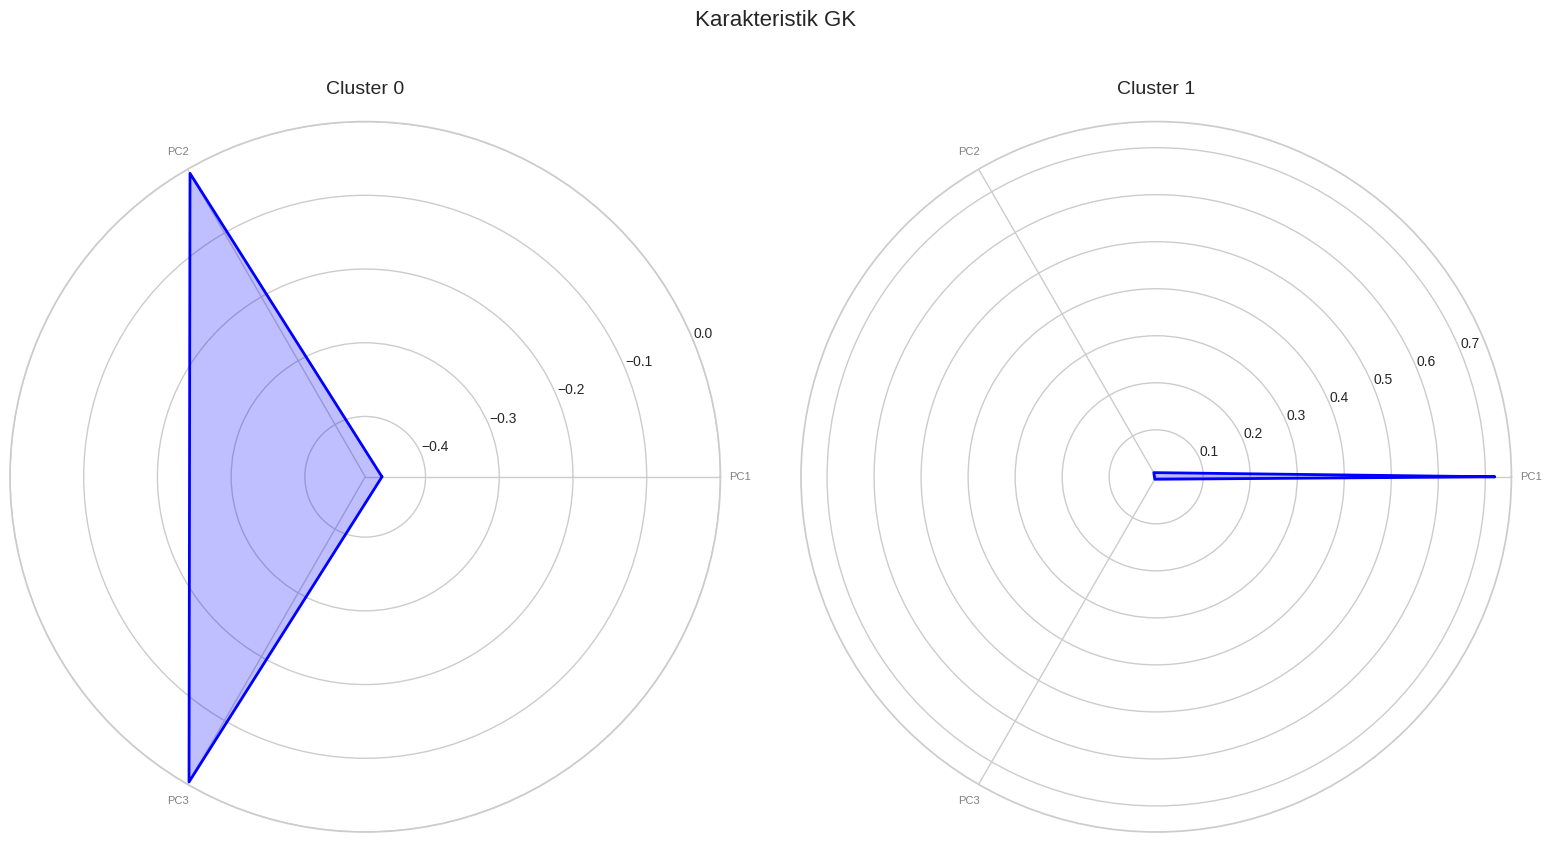

In [50]:
def create_radar_chart_clusters(position_list, df_dict, features_dict):
    """
    Create a radar chart for all clusters.

    Parameters:
    position_list: List of positions to be analyzed
    df_dict : Dictionary dataframe clustering results per position
    features_dict : Dictionary features clustering results per position
    """
    # Looping based on `position_list` parameter
    for position in position_list:
        # Get dataframe and features from dictionary by position
        df = df_dict[position]
        features = features_dict[position]
        
        # Take the number of clusters
        clusters = sorted(df['Class'].unique())
        n_clusters = len(clusters)

        # Create one figure with horizontal subplots
        fig, axes = plt.subplots(1, n_clusters, figsize=(8*n_clusters, 8), 
                                subplot_kw=dict(polar=True))

        # If there is only 1 cluster, axes need to be changed to an array.
        if n_clusters == 1:
            axes = [axes]

        # Looping each cluster
        for idx, cluster in enumerate(clusters):
            # Get data for a specific cluster
            cluster_mask = df['Class'] == cluster
            cluster_data = df[cluster_mask][features].mean().tolist()
            cluster_data.append(cluster_data[0])  # Close polygon
            
            # Create a corner for each feature
            angles = [n / float(len(features)) * 2 * np.pi for n in range(len(features))]
            angles += angles[:1]
            
            # Plot in the appropriate subplot
            axes[idx].plot(angles, cluster_data, linewidth=2, linestyle='solid', color='blue')
            axes[idx].fill(angles, cluster_data, color='blue', alpha=0.25)
            axes[idx].set_xticks(angles[:-1])
            axes[idx].set_xticklabels(features, color='grey', size=8)
            axes[idx].set_title(f'Cluster {cluster}', size=14, pad=20)
            
        plt.suptitle(f"Karakteristik {position}", size=16, y=1.05)
        plt.tight_layout()  # Use `tight_layout` to avoid overlap
        plt.show()

# Apply `create_radar_chart_clusters` function
create_radar_chart_clusters(position_category, cluster_results, pca_columns)

# References
- [Football players visualization](https://www.kaggle.com/code/quangnhatbui/football-players-visualization)